# Multiple Data Splits for Ensemble Training

This notebook has been updated to create five different train/eval/test splits from the original dataset for ensemble training, ensuring better diversity and more robust uncertainty estimation.

# Setup

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import AutoTokenizer, DataCollatorWithPadding, BertModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import Dataset, DatasetDict
import random
from gensim.models import Doc2Vec
from gensim.models.phrases import Phrases, Phraser
from gensim.models.doc2vec import TaggedDocument
from utils.functions import group_texts, sentiment_code, topic_code,party_deu, clean_text_loop, copy_weights, sentiment_code_coalition, topic_code_coalition
from utils.functions import train_loop, eval_loop, tokenize_function, cmp_scale, scale_func, d2v_reduct, check_weights_similar, compare_architectures, get_architecture_details, recode_tw
from utils.models import ContextScalePrediction, corpusIterator, phraseIterator
from safetensors.torch import load_file, save_file
from sklearn.decomposition import PCA
import pickle
import nltk
#nltk.download('stopwords') ## Remove comments and do it once if you haven't

In [2]:
torch.cuda.empty_cache() 
device = torch.device('cuda')
torch.cuda.get_device_name(device=None)


'NVIDIA RTX PRO 6000 Blackwell Workstation Edition'

In [3]:
## Pseudo-randomness for reproducibility
seed_val = 1234
torch.manual_seed(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)


# Small test of BERT embeddings

In [4]:
model_name = 'bert-base-cased'

In [5]:
model = BertModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [6]:
sentence_a = 'I went to the river bank'
sentence_b = 'I went to the bank by the river'
tok_a = tokenizer(sentence_a, return_tensors='pt')
tok_b = tokenizer(sentence_b, return_tensors='pt')

In [7]:
tok_a

{'input_ids': tensor([[ 101,  146, 1355, 1106, 1103, 2186, 3085,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [8]:
tok_b

{'input_ids': tensor([[ 101,  146, 1355, 1106, 1103, 3085, 1118, 1103, 2186,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [9]:
with torch.no_grad():
    outputs_a = model(**tok_a)
    outputs_b = model(**tok_b)
# Extract word embeddings from the last hidden layer
last_hidden_states_a = outputs_a.last_hidden_state
last_hidden_states_b = outputs_b.last_hidden_state

# Extract the word embedding for the first token (CLS token)
word_embedding_a = last_hidden_states_a[:, -2, :] ## 0 is the CLS token, river is the last token
word_embedding_b = last_hidden_states_b[:, 5, :]

In [10]:
np.corrcoef(word_embedding_a.numpy(), word_embedding_b.numpy()).round(2)

array([[1.  , 0.64],
       [0.64, 1.  ]])

# Implementation

### Data preparation

In [9]:
manifesto = pd.read_csv(os.path.join("data", "r_outputs","pulled_manifestoes.csv"), encoding="utf-8", dtype = {2: 'str', 18:'str'})

In [10]:
manifesto = manifesto[(manifesto.cmp_code.notna()) & ~(manifesto.cmp_code.isin(['H']))].reset_index(drop=True)
len(manifesto)

883323

In [11]:
manifesto['sentiment'] = manifesto['cmp_code'].apply(sentiment_code)
manifesto['topic'] = manifesto['cmp_code'].apply(topic_code)
manifesto['election'] = manifesto['date'].astype(str).str[:4]

In [12]:
manifesto.groupby(['topic','sentiment']).count()

text  text_en  cmp_code  eu_code  \
topic                       sentiment                                       
Agriculture - Protectionism left        19310    18296     19310      193   
                            right        2181     2030      2181        9   
Economics                   left        52420    50090     52420       80   
                            neutral     75141    71348     75141      103   
                            right       37940    36785     37940       62   
Education                   left        45505    44167     45505       10   
                            right         638      625       638        0   
Environment - Growth        left        64336    62320     64336       78   
                            neutral     20756    19608     20756        0   
                            right       10884    10336     10884       37   
European Integration        left        14003    13783     14003        1   
                            right        6090     5968      6090        1   
Fabrics of Society          left        36107    34285     36107       11   
                            neutral     18085    17796     18085       19   
                            right       52426    52025     52426       57   
Immigration                 left        12267    11180     12267       28   
                            right       17979    17888     17979        9   
International Relations     left        24660    24066     24660       18   
                            neutral      3033     2901      3033        6   
                            right        2190     2169      2190        2   
Labour and Social Welfare   left       184420   177051    184420       63   
                            neutral      4159     4070      4159        2   
                            right        6464     6432      6464        1   
Military                    left         4697     4442      4697        9   
                            right       10369    10309     10369       20   
Other                       neutral     75159    71899     75159       48   
Political System            left         2191     2191      2191        0   
                            neutral     44193    42953     44193       30   
                            right       35720    31305     35720      264   

                                          pos  manifesto_id   party    date  \
topic                       sentiment                                         
Agriculture - Protectionism left        19310         19310   19310   19310   
                            right        2181          2181    2181    2181   
Economics                   left        52420         52420   52420   52420   
                            neutral     75141         75141   75141   75141   
                            right       37940         37940   37940   37940   
Education                   left        45505         45505   45505   45505   
                            right         638           638     638     638   
Environment - Growth        left        64336         64336   64336   64336   
                            neutral     20756         20756   20756   20756   
                            right       10884         10884   10884   10884   
European Integration        left        14003         14003   14003   14003   
                            right        6090          6090    6090    6090   
Fabrics of Society          left        36107         36107   36107   36107   
                            neutral     18085         18085   18085   18085   
                            right       52426         52426   52426   52426   
Immigration                 left        12267         12267   12267   12267   
                            right       17979         17979   17979   17979   
International Relations     left        24660         24660   24660   24660   
                            neutral      3033          3033    3033    30

In [13]:
grouped_result = manifesto.groupby(['topic', 'sentiment', 'cmp_code']).size().reset_index(name='count')
grouped_result.to_csv('data/temps/categorization_table.csv', index=False)




In [14]:
manifesto.groupby('sentiment').count()

,text,text_en,cmp_code,eu_code,pos,manifesto_id,party,date,language,source,...,id,country,party_code,countryname,abbrev,name,edate,parfam,topic,election
sentiment,,,,,,,,,,,,,,,,,,,,,
left,459916,441871,459916,491,459916,459916,459916,459916,459916,459916,...,459916,459916,459916,459916,432200,459916,459916,459916,459916,459916
neutral,240526,230575,240526,208,240526,240526,240526,240526,240526,240526,...,240526,240526,240526,240526,225707,240526,240526,240526,240526,240526
right,182881,175872,182881,462,182881,182881,182881,182881,182881,182881,...,182881,182881,182881,182881,174907,182881,182881,182881,182881,182881


In [15]:
len(manifesto[manifesto.topic=="Military"])/len(manifesto)*100 ## minority group: 1.7%

1.7056048580190937

In [16]:
texts = manifesto['text'].tolist()

In [17]:
from statistics import stdev, mean
## Before
seq_len = [len(i.split()) for i in texts]
seq_len_mean = mean(seq_len)
seq_len_std = stdev(seq_len)
seq_len_max = max(seq_len)
seq_len_min = min(seq_len)
print('Mean length (word) is: {}'.format(seq_len_mean))
print('Std length (word) is: {}'.format(seq_len_std))
print('Min length (word) is: {}'.format(seq_len_min))
print('Max length (word) is: {}'.format(seq_len_max))

Mean length (word) is: 18.07444502180969
Std length (word) is: 11.17055383287234
Min length (word) is: 1
Max length (word) is: 269


<Axes: >

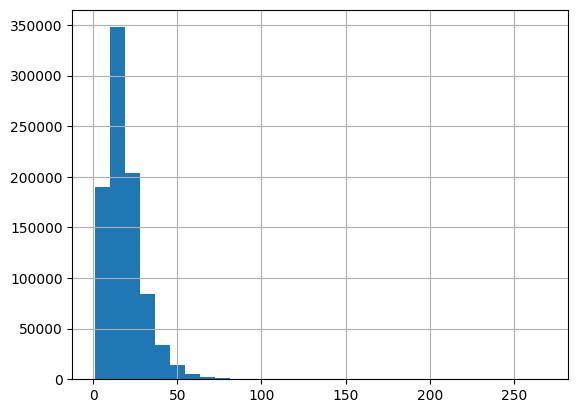

In [18]:
pd.Series(seq_len).hist(bins = 30)

In [19]:
results = group_texts(manifesto, 
                      ['countryname','election','party','cmp_code'], 'text', 
                      max_group_factor = 5)

In [20]:
manifesto_regrouped = pd.DataFrame(results)
manifesto_regrouped = manifesto_regrouped.explode('text').reset_index(drop=True)

In [21]:
df_cols = manifesto_regrouped['labels'].str.split(';', expand=True)
manifesto_regrouped = pd.concat([manifesto_regrouped, df_cols], axis=1)


In [22]:
manifesto_regrouped.columns = ['text', 'idx', 'country','election', 'party', 'cmp_code']

In [23]:
manifesto_regrouped.head()

,text,idx,country,election,party,cmp_code
0,Statt dessen soll ein Freiwilligen-Milizheer g...,Austria;1999;42110;104,Austria,1999,42110,104
1,"Weg von der Sicherheit durch Rüstung, Unsere S...",Austria;1999;42110;105,Austria,1999,42110,105
2,Die Militarisierung der EU bringt mehr Rüstung...,Austria;1999;42110;105,Austria,1999,42110,105
3,Bei einem Beitritt Österreichs könnten auch ös...,Austria;1999;42110;105,Austria,1999,42110,105
4,Seit 2 Jahren werden 500 Panzer für das österr...,Austria;1999;42110;105,Austria,1999,42110,105


In [24]:
manifesto_regrouped.loc[:,'sentiment'] = manifesto_regrouped['cmp_code'].apply(sentiment_code)
manifesto_regrouped.loc[:,'topic'] = manifesto_regrouped['cmp_code'].apply(topic_code)
manifesto_regrouped = manifesto_regrouped.drop_duplicates().reset_index(drop=True)


In [25]:
manifesto_regrouped.groupby(['topic','sentiment']).count()

text    idx  country  election  party  \
topic                       sentiment                                           
Agriculture - Protectionism left        7381   7381     7381      7381   7381   
                            right        935    935      935       935    935   
Economics                   left       20294  20294    20294     20294  20294   
                            neutral    29459  29459    29459     29459  29459   
                            right      14528  14528    14528     14528  14528   
Education                   left       17314  17314    17314     17314  17314   
                            right        257    257      257       257    257   
Environment - Growth        left       24621  24621    24621     24621  24621   
                            neutral     7635   7635     7635      7635   7635   
                            right       4203   4203     4203      4203   4203   
European Integration        left        5481   5481     5481      5481   5481   
                            right       2428   2428     2428      2428   2428   
Fabrics of Society          left       14002  14002    14002     14002  14002   
                            neutral     7041   7041     7041      7041   7041   
                            right      19632  19632    19632     19632  19632   
Immigration                 left        4817   4817     4817      4817   4817   
                            right       6699   6699     6699      6699   6699   
International Relations     left        9051   9051     9051      9051   9051   
                            neutral     1160   1160     1160      1160   1160   
                            right        898    898      898       898    898   
Labour and Social Welfare   left       70547  70547    70547     70547  70547   
                            neutral     1530   1530     1530      1530   1530   
                            right       2570   2570     2570      2570   2570   
Military                    left        1798   1798     1798      1798   1798   
                            right       3800   3800     3800      3800   3800   
Other                       neutral    28030  28030    28030     28030  28030   
Political System            left         934    934      934       934    934   
                            neutral    16566  16566    16566     16566  16566   
                            right      13801  13801    13801     13801  13801   

                                       cmp_code  
topic                       sentiment            
Agriculture - Protectionism left           7381  
                            right           935  
Economics                   left          20294  
                            neutral       29459  
                            right         14528  
Education                   left          17314  
                            right           257  
Environment - Growth        left          24621  
                            neutral        7635  
                            right          4203  
European Integration        left           5481  
                            right          2428  
Fabrics of Society          left          14002  
                            neutral        7041  
                            right         19632  
Immigration                 left           4817  
                            right          6699  
International Relations     left           9051  
                            neutral        1160  
                            right           898  
Labour and Social Welfare   left          70547  
                            neutral        1530  
                            right          2570  
Military                    left           1798  
                            right          3800  
Other                       neutral       28030  
Political System            left            934  
                            neutral       16566  
                            

In [26]:
texts = manifesto_regrouped['text'].tolist()
from statistics import stdev, mean
## Before
seq_len = [len(i.split()) for i in texts]
seq_len_mean = mean(seq_len)
seq_len_std = stdev(seq_len)
seq_len_max = max(seq_len)
seq_len_min = min(seq_len)
print('Mean length (word) is: {}'.format(seq_len_mean))
print('Std length (word) is: {}'.format(seq_len_std))
print('Min length (word) is: {}'.format(seq_len_min))
print('Max length (word) is: {}'.format(seq_len_max))

Mean length (word) is: 74.3312271051415
Std length (word) is: 36.82022801372765
Min length (word) is: 1
Max length (word) is: 374


<Axes: >

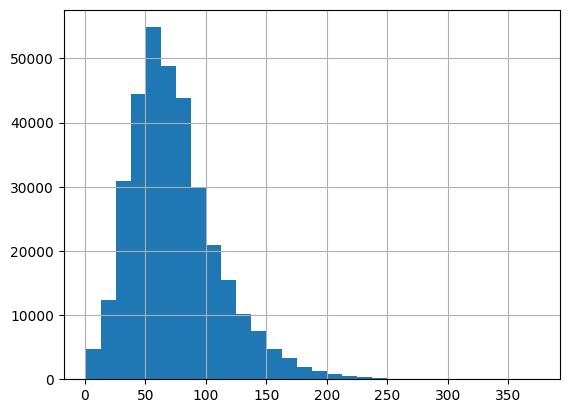

In [27]:
pd.Series(seq_len).hist(bins = 30)

In [28]:
manifesto_regrouped.to_csv('data/temps/manifesto_regrouped.csv', encoding='utf-8', index=False)
manifesto.to_csv('data/temps/manifesto.csv', encoding='utf-8', index=False)

### Preparing dataloaders 

In [4]:
manifesto = pd.read_csv('data/temps/manifesto.csv', encoding='utf-8', dtype={2:'str',18: 'str'})
manifesto_regrouped = pd.read_csv('data/temps/manifesto_regrouped.csv', encoding='utf-8')

In [5]:
manifesto_reduced = manifesto_regrouped[['topic','sentiment','text']].reset_index(drop=True)

In [6]:
model_name = 'xlm-roberta-large'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

In [7]:
manifesto_reduced['topic_sentiment'] = manifesto_reduced['topic'] + '_' + manifesto_reduced['sentiment']

In [8]:
manifesto_dataset = Dataset.from_pandas(manifesto_reduced)
manifesto_dataset = manifesto_dataset.class_encode_column('topic')
manifesto_dataset = manifesto_dataset.class_encode_column('sentiment')
manifesto_dataset = manifesto_dataset.class_encode_column('topic_sentiment')



Casting to class labels:   0%|          | 0/337412 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/337412 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/337412 [00:00<?, ? examples/s]

In [9]:
## Save class labels
import pickle
topic_labels = manifesto_dataset.features['topic'].names
file_path = 'data/temps/topic_labels'
with open(file_path, 'wb') as fp:
    pickle.dump(topic_labels, fp)

sentiment_labels = manifesto_dataset.features['sentiment'].names
file_path = 'data/temps/sentiment_labels'
with open(file_path, 'wb') as fp:
    pickle.dump(sentiment_labels, fp)

In [10]:
train_test = manifesto_dataset.train_test_split(test_size=0.1, stratify_by_column='topic_sentiment', seed=seed_val)
train_eval = train_test['train'].train_test_split(test_size=0.3, stratify_by_column='topic_sentiment', seed=seed_val )

In [11]:
manifesto_datasets = DatasetDict({
    'train': train_eval['train'],
    'test': train_test['test'],
    'eval': train_eval['test']
})
manifesto_datasets

DatasetDict({
    train: Dataset({
        features: ['topic', 'sentiment', 'text', 'topic_sentiment'],
        num_rows: 212569
    })
    test: Dataset({
        features: ['topic', 'sentiment', 'text', 'topic_sentiment'],
        num_rows: 33742
    })
    eval: Dataset({
        features: ['topic', 'sentiment', 'text', 'topic_sentiment'],
        num_rows: 91101
    })
})

In [12]:
tokenized_datasets = manifesto_datasets.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 512}, 
                                            remove_columns=['text', 'topic_sentiment'])
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

Map:   0%|          | 0/212569 [00:00<?, ? examples/s]

Map:   0%|          | 0/33742 [00:00<?, ? examples/s]

Map:   0%|          | 0/91101 [00:00<?, ? examples/s]

['topic', 'sentiment', 'input_ids', 'attention_mask']

In [13]:
train_dataloader = DataLoader(tokenized_datasets['train'], batch_size=16, shuffle=True, collate_fn = data_collator)
test_dataloader = DataLoader(tokenized_datasets['test'], batch_size=16, shuffle=False, collate_fn = data_collator)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=16, shuffle=False, collate_fn = data_collator)

### Base Model

In [14]:
num_topics = len(set(manifesto_reduced['topic']))
num_sentiments = len(set(manifesto_reduced['sentiment']))
model = ContextScalePrediction(roberta_model=model_name, 
                               num_topics=num_topics, 
                               num_sentiments=num_sentiments,
                               lora=False).to(device)



In [15]:
n_epochs=5
total_steps = len(train_dataloader)*n_epochs
warmup = total_steps*0.1
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5) 
scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps=total_steps, num_warmup_steps=warmup)
criterion_sent = nn.CrossEntropyLoss()
criterion_topic =  nn.CrossEntropyLoss()


In [16]:
for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")
    timing_log = train_loop(train_dataloader, model,optimizer, scheduler, device, criterion_sent, criterion_topic, sentiment_var='sentiment',
               topic_var='topic', timing_log=True)
    eval_loop(eval_dataloader, model, device, criterion_sent, criterion_topic, sentiment_var='sentiment', topic_var='topic')

    

Epoch: 1

Training...
Batch 100: loss=3.751638, elapsed=12.38s, remaining=1556.61s.
Batch 200: loss=3.698838, elapsed=23.59s, remaining=1485.39s.
Batch 300: loss=3.630751, elapsed=34.56s, remaining=1441.65s.
Batch 400: loss=3.565981, elapsed=45.33s, remaining=1410.88s.
Batch 500: loss=3.504886, elapsed=55.74s, remaining=1377.90s.
Batch 600: loss=3.434784, elapsed=66.58s, remaining=1359.77s.
Batch 700: loss=3.356035, elapsed=77.50s, remaining=1346.71s.
Batch 800: loss=3.267085, elapsed=88.44s, remaining=1334.20s.
Batch 900: loss=3.179063, elapsed=99.50s, remaining=1322.91s.
Batch 1000: loss=3.092085, elapsed=110.39s, remaining=1310.51s.
Batch 1100: loss=3.009968, elapsed=121.31s, remaining=1298.75s.
Batch 1200: loss=2.938461, elapsed=132.15s, remaining=1286.04s.
Batch 1300: loss=2.872399, elapsed=142.86s, remaining=1272.81s.
Batch 1400: loss=2.807210, elapsed=153.71s, remaining=1260.81s.
Batch 1500: loss=2.754112, elapsed=164.21s, remaining=1246.37s.
Batch 1600: loss=2.702598, elapsed=1

In [17]:
state_dict = model.state_dict()
save_file(state_dict, 'results/models/manifesto_ContextScalePrediction_base/model.safetensors')

In [18]:
outputs_base = scale_func(test_dataloader, 
               model, 
               device, 
               topic_label='topic', 
               sentiment_label='sentiment', 
               timing_log=True,
               use_ground_truth_topic=True)

Start predicting labels...
Labels for topic are provided. They will be used for position scaling!
Elapsed time: 45.66s, Estimated remaining time: 50.64s
Elapsed time: 91.96s, Estimated remaining time: 5.01s
Start computing position scores


In [19]:
outputs_base['res_table_topic']

,f1,precision,recall,accuracy
0,0.83,0.82,0.84,0.84
1,0.86,0.86,0.86,0.86
2,0.90,0.90,0.90,0.90
3,0.89,0.88,0.90,0.90
4,0.86,0.86,0.86,0.86
5,0.83,0.83,0.83,0.83
6,0.79,0.79,0.80,0.80
7,0.87,0.86,0.87,0.87
8,0.90,0.89,0.90,0.90
9,0.90,0.91,0.89,0.89


In [20]:
outputs_base['res_table_topic']['f1'].mean().round(2)

0.86

In [21]:
outputs_base['res_table_sentiment']

,f1,precision,recall,accuracy
0,0.91,0.90,0.92,0.92
1,0.84,0.85,0.83,0.83
2,0.82,0.83,0.81,0.81


In [22]:
outputs_base['res_table_sentiment']['f1'].mean().round(2)

0.86

In [23]:
file_path = 'data/temps/outputs_base'
with open(file_path, "wb") as file:
    pickle.dump(outputs_base, file)

In [24]:
outputs_base['res_table_sentiment'].to_csv('results/classification results/base_sentiment.csv', index=False)
outputs_base['res_table_topic'].to_csv('results/classification results/base_topic.csv', index=False)


### Model with simple flow of information

In [25]:
num_topics = len(set(manifesto_reduced['topic']))
num_sentiments = len(set(manifesto_reduced['sentiment']))
model = ContextScalePrediction(roberta_model=model_name, 
                               num_topics=num_topics, 
                               num_sentiments=num_sentiments,
                               lora=False,
                               use_simple_flow=True).to(device)



In [26]:
n_epochs=5
total_steps = len(train_dataloader)*n_epochs
warmup = total_steps*0.1
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5) 
scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps=total_steps, num_warmup_steps=warmup)
criterion_sent = nn.CrossEntropyLoss()
criterion_topic =  nn.CrossEntropyLoss()


In [27]:
for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")
    timing_log = train_loop(train_dataloader, model,optimizer, scheduler, device, criterion_sent, criterion_topic, sentiment_var='sentiment',
               topic_var='topic', timing_log=True)
    eval_loop(eval_dataloader, model, device, criterion_sent, criterion_topic, sentiment_var='sentiment', topic_var='topic')

    

Epoch: 1

Training...
Batch 100: loss=3.744288, elapsed=10.74s, remaining=1360.48s.
Batch 200: loss=3.730988, elapsed=21.25s, remaining=1343.60s.
Batch 300: loss=3.673736, elapsed=31.78s, remaining=1331.60s.
Batch 400: loss=3.594197, elapsed=42.23s, remaining=1317.30s.
Batch 500: loss=3.517949, elapsed=52.50s, remaining=1300.04s.
Batch 600: loss=3.440967, elapsed=62.89s, remaining=1287.82s.
Batch 700: loss=3.344678, elapsed=73.20s, remaining=1274.38s.
Batch 800: loss=3.247745, elapsed=83.57s, remaining=1262.78s.
Batch 900: loss=3.152653, elapsed=94.15s, remaining=1254.37s.
Batch 1000: loss=3.059615, elapsed=104.69s, remaining=1245.10s.
Batch 1100: loss=2.976745, elapsed=115.22s, remaining=1235.47s.
Batch 1200: loss=2.903974, elapsed=125.73s, remaining=1225.41s.
Batch 1300: loss=2.833787, elapsed=136.33s, remaining=1216.14s.
Batch 1400: loss=2.772936, elapsed=146.71s, remaining=1204.79s.
Batch 1500: loss=2.717446, elapsed=157.29s, remaining=1195.18s.
Batch 1600: loss=2.665250, elapsed=1

In [28]:
state_dict = model.state_dict()
save_file(state_dict, 'results/models/manifesto_ContextScalePrediction_sf/model.safetensors')

In [29]:
outputs_sf = scale_func(test_dataloader, 
               model, 
               device, 
               topic_label='topic', 
               sentiment_label='sentiment', 
               timing_log=True,
               use_ground_truth_topic=True)

Start predicting labels...
Labels for topic are provided. They will be used for position scaling!
Elapsed time: 45.56s, Estimated remaining time: 50.53s
Elapsed time: 91.37s, Estimated remaining time: 4.98s
Start computing position scores


In [30]:
outputs_sf['res_table_topic']

,f1,precision,recall,accuracy
0,0.83,0.82,0.84,0.84
1,0.86,0.85,0.87,0.87
2,0.90,0.90,0.90,0.90
3,0.89,0.90,0.89,0.89
4,0.87,0.86,0.88,0.88
5,0.83,0.83,0.83,0.83
6,0.79,0.79,0.79,0.79
7,0.86,0.86,0.86,0.86
8,0.89,0.89,0.89,0.89
9,0.89,0.89,0.89,0.89


In [31]:
outputs_sf['res_table_topic']['f1'].mean().round(2)

0.86

In [32]:
outputs_sf['res_table_sentiment']

,f1,precision,recall,accuracy
0,0.90,0.90,0.91,0.91
1,0.84,0.84,0.83,0.83
2,0.82,0.82,0.82,0.82


In [33]:
outputs_sf['res_table_sentiment']['f1'].mean().round(2)

0.85

In [34]:
file_path = 'data/temps/outputs_sf'
with open(file_path, "wb") as file:
    pickle.dump(outputs_sf, file)

In [35]:
outputs_sf['res_table_sentiment'].to_csv('results/classification results/sf_sentiment.csv', index=False)
outputs_sf['res_table_topic'].to_csv('results/classification results/sf_topic.csv', index=False)


### Model with shared attention

In [36]:
num_topics = len(set(manifesto_reduced['topic']))
num_sentiments = len(set(manifesto_reduced['sentiment']))
model = ContextScalePrediction(roberta_model=model_name, 
                               num_topics=num_topics, 
                               num_sentiments=num_sentiments,
                               lora=False,
                               use_shared_attention=True).to(device)



In [37]:
n_epochs=5
total_steps = len(train_dataloader)*n_epochs
warmup = total_steps*0.1
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5) 
scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps=total_steps, num_warmup_steps=warmup)
criterion_sent = nn.CrossEntropyLoss()
criterion_topic =  nn.CrossEntropyLoss()


In [38]:
for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")
    timing_log = train_loop(train_dataloader, model,optimizer, scheduler, device, criterion_sent, criterion_topic, sentiment_var='sentiment',
               topic_var='topic', timing_log=True)
    eval_loop(eval_dataloader, model, device, criterion_sent, criterion_topic, sentiment_var='sentiment', topic_var='topic')

    

Epoch: 1

Training...
Batch 100: loss=3.516776, elapsed=10.98s, remaining=1389.96s.
Batch 200: loss=3.473603, elapsed=21.79s, remaining=1376.26s.
Batch 300: loss=3.422491, elapsed=32.55s, remaining=1362.36s.
Batch 400: loss=3.382882, elapsed=42.99s, remaining=1340.16s.
Batch 500: loss=3.322140, elapsed=53.69s, remaining=1328.40s.
Batch 600: loss=3.243311, elapsed=64.18s, remaining=1313.02s.
Batch 700: loss=3.150156, elapsed=75.06s, remaining=1305.93s.
Batch 800: loss=3.050005, elapsed=85.93s, remaining=1297.85s.
Batch 900: loss=2.955178, elapsed=96.59s, remaining=1286.37s.
Batch 1000: loss=2.869950, elapsed=107.43s, remaining=1277.18s.
Batch 1100: loss=2.792143, elapsed=118.24s, remaining=1267.31s.
Batch 1200: loss=2.721892, elapsed=128.98s, remaining=1256.67s.
Batch 1300: loss=2.659945, elapsed=139.60s, remaining=1244.88s.
Batch 1400: loss=2.600168, elapsed=150.26s, remaining=1233.63s.
Batch 1500: loss=2.542570, elapsed=160.97s, remaining=1222.73s.
Batch 1600: loss=2.491336, elapsed=1

In [39]:
state_dict = model.state_dict()
save_file(state_dict, 'results/models/manifesto_ContextScalePrediction_sa/model.safetensors')

In [40]:
outputs_sa = scale_func(test_dataloader, 
               model, 
               device, 
               topic_label='topic', 
               sentiment_label='sentiment', 
               timing_log=True,
               use_ground_truth_topic=True)

Start predicting labels...
Labels for topic are provided. They will be used for position scaling!
Elapsed time: 45.65s, Estimated remaining time: 50.62s
Elapsed time: 91.61s, Estimated remaining time: 4.99s
Start computing position scores


In [41]:
outputs_sa['res_table_topic']

,f1,precision,recall,accuracy
0,0.82,0.82,0.83,0.83
1,0.86,0.86,0.87,0.87
2,0.90,0.89,0.90,0.90
3,0.90,0.89,0.90,0.90
4,0.87,0.86,0.87,0.87
5,0.83,0.84,0.83,0.83
6,0.79,0.79,0.79,0.79
7,0.87,0.87,0.86,0.86
8,0.89,0.89,0.89,0.89
9,0.90,0.89,0.91,0.91


In [42]:
outputs_sa['res_table_topic']['f1'].mean().round(2)

0.86

In [43]:
outputs_sa['res_table_sentiment']

,f1,precision,recall,accuracy
0,0.91,0.90,0.91,0.91
1,0.84,0.85,0.83,0.83
2,0.82,0.83,0.82,0.82


In [44]:
outputs_sa['res_table_sentiment']['f1'].mean().round(2)

0.86

In [45]:
file_path = 'data/temps/outputs_sa'
with open(file_path, "wb") as file:
    pickle.dump(outputs_sa, file)

In [46]:
outputs_sa['res_table_sentiment'].to_csv('results/classification results/sa_sentiment.csv', index=False)
outputs_sa['res_table_topic'].to_csv('results/classification results/sa_topic.csv', index=False)


### Model with dynamic gating

In [15]:
num_topics = len(set(manifesto_reduced['topic']))
num_sentiments = len(set(manifesto_reduced['sentiment']))
model = ContextScalePrediction(roberta_model=model_name, 
                               num_topics=num_topics, 
                               num_sentiments=num_sentiments,
                               lora=False,
                               use_dynamic_gating=True).to(device)



In [16]:
n_epochs=5
total_steps = len(train_dataloader)*n_epochs
warmup = total_steps*0.1
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5) 
scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps=total_steps, num_warmup_steps=warmup)
criterion_sent = nn.CrossEntropyLoss()
criterion_topic =  nn.CrossEntropyLoss()


In [17]:
for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")
    timing_log = train_loop(train_dataloader, model,optimizer, scheduler, device, criterion_sent, criterion_topic, sentiment_var='sentiment',
               topic_var='topic', timing_log=True)
    eval_loop(eval_dataloader, model, device, criterion_sent, criterion_topic, sentiment_var='sentiment', topic_var='topic')

    

Epoch: 1

Training...
Batch 100: loss=3.635184, elapsed=12.06s, remaining=1522.24s.
Batch 200: loss=3.591522, elapsed=22.56s, remaining=1419.77s.
Batch 300: loss=3.541844, elapsed=32.83s, remaining=1368.64s.
Batch 400: loss=3.491652, elapsed=43.26s, remaining=1342.44s.
Batch 500: loss=3.436597, elapsed=54.04s, remaining=1331.66s.
Batch 600: loss=3.367661, elapsed=64.29s, remaining=1310.26s.
Batch 700: loss=3.288763, elapsed=74.42s, remaining=1289.36s.
Batch 800: loss=3.185872, elapsed=84.74s, remaining=1274.32s.
Batch 900: loss=3.090013, elapsed=95.11s, remaining=1261.15s.
Batch 1000: loss=2.998415, elapsed=105.25s, remaining=1245.70s.
Batch 1100: loss=2.915122, elapsed=115.63s, remaining=1234.00s.
Batch 1200: loss=2.838422, elapsed=125.75s, remaining=1219.92s.
Batch 1300: loss=2.767479, elapsed=136.04s, remaining=1207.93s.
Batch 1400: loss=2.706929, elapsed=146.11s, remaining=1194.44s.
Batch 1500: loss=2.652048, elapsed=155.92s, remaining=1179.29s.
Batch 1600: loss=2.599709, elapsed=1

In [18]:
state_dict = model.state_dict()
save_file(state_dict, 'results/models/manifesto_ContextScalePrediction_dg/model.safetensors')

In [19]:
outputs_dg = scale_func(test_dataloader, 
               model, 
               device, 
               topic_label='topic', 
               sentiment_label='sentiment', 
               timing_log=True,
               use_ground_truth_topic=True)

Start predicting labels...
Labels for topic are provided. They will be used for position scaling!
Elapsed time: 45.44s, Estimated remaining time: 50.39s
Elapsed time: 91.18s, Estimated remaining time: 4.97s
Start computing position scores


In [20]:
outputs_dg['res_table_topic']

,f1,precision,recall,accuracy
0,0.84,0.83,0.84,0.84
1,0.86,0.85,0.87,0.87
2,0.89,0.89,0.90,0.90
3,0.89,0.90,0.89,0.89
4,0.87,0.87,0.87,0.87
5,0.83,0.84,0.82,0.82
6,0.80,0.79,0.80,0.80
7,0.86,0.85,0.88,0.88
8,0.89,0.89,0.90,0.90
9,0.90,0.91,0.88,0.88


In [21]:
outputs_dg['res_table_topic']['f1'].mean().round(2)

0.86

In [22]:
outputs_dg['res_table_sentiment']

,f1,precision,recall,accuracy
0,0.91,0.90,0.91,0.91
1,0.84,0.85,0.83,0.83
2,0.82,0.83,0.81,0.81


In [23]:
outputs_dg['res_table_sentiment']['f1'].mean().round(2)

0.86

In [24]:
file_path = 'data/temps/outputs_dg'
with open(file_path, "wb") as file:
    pickle.dump(outputs_dg, file)

In [25]:
outputs_dg['res_table_sentiment'].to_csv('results/classification results/dg_sentiment.csv', index=False)
outputs_dg['res_table_topic'].to_csv('results/classification results/dg_topic.csv', index=False)


## Main model, using 90% of data

In [26]:
manifesto_datasets = DatasetDict({
    'train': train_test['train'],
    'test': train_test['test']
})
manifesto_datasets

DatasetDict({
    train: Dataset({
        features: ['topic', 'sentiment', 'text', 'topic_sentiment'],
        num_rows: 303670
    })
    test: Dataset({
        features: ['topic', 'sentiment', 'text', 'topic_sentiment'],
        num_rows: 33742
    })
})

In [27]:
tokenized_datasets = manifesto_datasets.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 512}, 
                                            remove_columns=['text', 'topic_sentiment'])
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

Map:   0%|          | 0/303670 [00:00<?, ? examples/s]

Map:   0%|          | 0/33742 [00:00<?, ? examples/s]

['topic', 'sentiment', 'input_ids', 'attention_mask']

In [28]:
train_dataloader = DataLoader(tokenized_datasets['train'], batch_size=16, shuffle=True, collate_fn = data_collator)
test_dataloader = DataLoader(tokenized_datasets['test'], batch_size=16, shuffle=False, collate_fn = data_collator)

In [29]:
num_topics = len(set(manifesto_reduced['topic']))
num_sentiments = len(set(manifesto_reduced['sentiment']))
model = ContextScalePrediction(roberta_model=model_name, 
                               num_topics=num_topics, 
                               num_sentiments=num_sentiments,
                               lora=False,
                               use_shared_attention=True).to(device)



In [30]:
n_epochs=5
total_steps = len(train_dataloader)*n_epochs
warmup = total_steps*0.1
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5) 
scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps=total_steps, num_warmup_steps=warmup)
criterion_sent = nn.CrossEntropyLoss()
criterion_topic =  nn.CrossEntropyLoss()


In [31]:
for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")
    timing_log = train_loop(train_dataloader, model,optimizer, scheduler, device, criterion_sent, criterion_topic, sentiment_var='sentiment',
               topic_var='topic', timing_log=True)
    

Epoch: 1

Training...
Batch 100: loss=3.756312, elapsed=10.85s, remaining=1963.96s.
Batch 200: loss=3.712485, elapsed=21.22s, remaining=1920.29s.
Batch 300: loss=3.623567, elapsed=31.88s, remaining=1917.49s.
Batch 400: loss=3.548142, elapsed=42.55s, remaining=1912.07s.
Batch 500: loss=3.488375, elapsed=53.44s, remaining=1914.35s.
Batch 600: loss=3.419642, elapsed=64.35s, remaining=1910.62s.
Batch 700: loss=3.352318, elapsed=74.97s, remaining=1895.51s.
Batch 800: loss=3.266815, elapsed=85.50s, remaining=1881.09s.
Batch 900: loss=3.181134, elapsed=96.25s, remaining=1873.05s.
Batch 1000: loss=3.090784, elapsed=106.64s, remaining=1855.91s.
Batch 1100: loss=3.012903, elapsed=117.22s, remaining=1844.84s.
Batch 1200: loss=2.933968, elapsed=127.76s, remaining=1833.88s.
Batch 1300: loss=2.862694, elapsed=138.71s, remaining=1827.22s.
Batch 1400: loss=2.798119, elapsed=149.27s, remaining=1815.74s.
Batch 1500: loss=2.735228, elapsed=160.09s, remaining=1806.58s.
Batch 1600: loss=2.680820, elapsed=1

In [33]:
state_dict = model.state_dict()
save_file(state_dict, 'results/models/manifesto_ContextScalePrediction_main/model.safetensors')

In [34]:
outputs_main = scale_func(test_dataloader, 
               model, 
               device, 
               topic_label='topic', 
               sentiment_label='sentiment', 
               timing_log=True,
               use_ground_truth_topic=True)

Start predicting labels...
Labels for topic are provided. They will be used for position scaling!
Elapsed time: 47.78s, Estimated remaining time: 52.99s
Elapsed time: 94.13s, Estimated remaining time: 5.13s
Start computing position scores


In [35]:
outputs_main['res_table_topic']

,f1,precision,recall,accuracy
0,0.85,0.82,0.87,0.87
1,0.88,0.88,0.88,0.88
2,0.91,0.90,0.92,0.92
3,0.91,0.91,0.91,0.91
4,0.88,0.87,0.89,0.89
5,0.85,0.86,0.85,0.85
6,0.82,0.82,0.83,0.83
7,0.88,0.88,0.89,0.89
8,0.91,0.90,0.91,0.91
9,0.91,0.91,0.92,0.92


In [36]:
outputs_main['res_table_topic']['f1'].mean().round(2)

0.87

In [37]:
outputs_main['res_table_sentiment']

,f1,precision,recall,accuracy
0,0.92,0.92,0.93,0.93
1,0.87,0.88,0.86,0.86
2,0.85,0.85,0.85,0.85


In [38]:
outputs_main['res_table_sentiment']['f1'].mean().round(2)

0.88

In [40]:
file_path = 'data/temps/outputs_main'
with open(file_path, "wb") as file:
    pickle.dump(outputs_main, file)

In [41]:
outputs_main['res_table_sentiment'].to_csv('results/classification results/main_sentiment.csv', index=False)
outputs_main['res_table_topic'].to_csv('results/classification results/main_topic.csv', index=False)


## Scaling party positions 

In [26]:
manifesto = pd.read_csv('data/temps/manifesto.csv', encoding='utf-8', dtype={2:'str',18: 'str'})
manifesto_regrouped = pd.read_csv('data/temps/manifesto_regrouped.csv', encoding='utf-8')

#### For all country-party-year

In [27]:
manifesto_regrouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337412 entries, 0 to 337411
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   text       337412 non-null  object 
 1   idx        337412 non-null  object 
 2   country    337412 non-null  object 
 3   election   337412 non-null  int64  
 4   party      337412 non-null  int64  
 5   cmp_code   337412 non-null  float64
 6   sentiment  337412 non-null  object 
 7   topic      337412 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 20.6+ MB


In [28]:
lr_kws = dict({'left': 'left', 'right': 'right'})

In [29]:
absscale, relscale, logscale, name_ls = cmp_scale(manifesto, text_var = 'text', group_vars=['countryname','party','election'], lr_kws = lr_kws, sent_var='sentiment')

In [30]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)


In [31]:
num_topics = 12
num_sentiments = 3
scaling_model = ContextScalePrediction(roberta_model=model_name, num_topics=num_topics, num_sentiments=num_sentiments,lora=False,
                                       use_shared_attention=True).to(device)


In [32]:
loaded_tensors = load_file('results/models/manifesto_ContextScalePrediction_main/model.safetensors')
scaling_model.load_state_dict(loaded_tensors)
model=None

In [33]:
tokenized_dataset = manifesto_dataset.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 512}, 
                                            remove_columns=['text', 'topic_sentiment'])
tokenized_dataset.set_format("torch")
tokenized_dataset.column_names

Map:   0%|          | 0/337412 [00:00<?, ? examples/s]

['topic', 'sentiment', 'input_ids', 'attention_mask']

In [34]:
pred_dataloader = DataLoader(tokenized_dataset, batch_size=16, shuffle=False, collate_fn = data_collator)

In [35]:
outputs_all = scale_func(pred_dataloader, 
               scaling_model, 
               device, 
               topic_label='topic', 
               sentiment_label='sentiment', 
               timing_log=True,
               use_ground_truth_topic=True)

Start predicting labels...
Labels for topic are provided. They will be used for position scaling!
Elapsed time: 34.33s, Estimated remaining time: 689.66s
Elapsed time: 77.89s, Estimated remaining time: 743.39s
Elapsed time: 120.18s, Estimated remaining time: 724.67s
Elapsed time: 163.04s, Estimated remaining time: 696.55s
Elapsed time: 203.13s, Estimated remaining time: 653.62s
Elapsed time: 237.77s, Estimated remaining time: 597.96s
Elapsed time: 271.47s, Estimated remaining time: 546.39s
Elapsed time: 308.70s, Estimated remaining time: 505.07s
Elapsed time: 354.65s, Estimated remaining time: 476.38s
Elapsed time: 394.39s, Estimated remaining time: 437.34s
Elapsed time: 435.36s, Estimated remaining time: 399.30s
Elapsed time: 467.14s, Estimated remaining time: 353.82s
Elapsed time: 498.68s, Estimated remaining time: 310.30s
Elapsed time: 530.14s, Estimated remaining time: 268.44s
Elapsed time: 561.77s, Estimated remaining time: 228.04s
Elapsed time: 607.49s, Estimated remaining time: 

In [36]:
list_names = manifesto_dataset.features['sentiment'].names
name_sentiment_dict = dict([(x,y) for x,y in enumerate(list_names)])
list_names = manifesto_dataset.features['topic'].names
name_topic_dict = dict([(x,y) for x,y in enumerate(list_names)])


In [37]:
name_topic_dict

{0: 'Agriculture - Protectionism',
 1: 'Economics',
 2: 'Education',
 3: 'Environment - Growth',
 4: 'European Integration',
 5: 'Fabrics of Society',
 6: 'Immigration',
 7: 'International Relations',
 8: 'Labour and Social Welfare',
 9: 'Military',
 10: 'Other',
 11: 'Political System'}

In [38]:
manifesto_regrouped.loc[:,'position_scores'] = outputs_all['position_scores'].flatten()
manifesto_regrouped.loc[:,'pred_sentiment_index'] = outputs_all['pred_sentiment']
manifesto_regrouped.loc[:,'pred_sentiment'] = manifesto_regrouped.pred_sentiment_index.map(name_sentiment_dict)
manifesto_regrouped.loc[:,'pred_topic_index'] = outputs_all['pred_topics']
manifesto_regrouped.loc[:,'pred_topic'] = manifesto_regrouped.pred_topic_index.map(name_topic_dict)

In [39]:
columns  =['country','party', 'election','mean_score', 'se_score']
df = pd.DataFrame(columns=columns)

for name, group in manifesto_regrouped.groupby(['country','party','election']):
    mean_score = group['position_scores'].mean()
    se_score = group['position_scores'].std()/np.sqrt(len(group))
    df_temp = pd.DataFrame([[str(group.iloc[0,group.columns.get_loc('country')]),
                             str(group.iloc[0,group.columns.get_loc('party')]), 
                    str(group.iloc[0,group.columns.get_loc('election')]), 
               mean_score, se_score]], columns = columns)
    df = (df_temp if df.empty else pd.concat([df, df_temp], ignore_index=True))

In [40]:
df['lr_log'] = logscale
df['lr_abs'] = absscale



In [41]:
np.corrcoef(df['lr_log'], df['mean_score'])

array([[1.        , 0.90054232],
       [0.90054232, 1.        ]])

In [42]:
## Save df 
df.to_csv('data/py_outputs/cs_gen.csv', index=False)

In [43]:
manifesto_regrouped.head()

,text,idx,country,election,party,cmp_code,sentiment,topic,position_scores,pred_sentiment_index,pred_sentiment,pred_topic_index,pred_topic
0,Statt dessen soll ein Freiwilligen-Milizheer g...,Austria;1999;42110;104,Austria,1999,42110,104.0,right,Military,0.755618,2,right,9,Military
1,"Weg von der Sicherheit durch Rüstung, Unsere S...",Austria;1999;42110;105,Austria,1999,42110,105.0,left,Military,-0.884001,0,left,9,Military
2,Die Militarisierung der EU bringt mehr Rüstung...,Austria;1999;42110;105,Austria,1999,42110,105.0,left,Military,-0.846234,0,left,9,Military
3,Bei einem Beitritt Österreichs könnten auch ös...,Austria;1999;42110;105,Austria,1999,42110,105.0,left,Military,-0.860604,0,left,9,Military
4,Seit 2 Jahren werden 500 Panzer für das österr...,Austria;1999;42110;105,Austria,1999,42110,105.0,left,Military,-0.864315,0,left,9,Military


In [44]:
outputs_all['res_table_sentiment']

,f1,precision,recall,accuracy
0,0.97,0.97,0.98,0.98
1,0.96,0.96,0.95,0.95
2,0.95,0.95,0.95,0.95


In [45]:
outputs_all['res_table_topic']

,f1,precision,recall,accuracy
0,0.95,0.94,0.96,0.96
1,0.96,0.96,0.96,0.96
2,0.98,0.97,0.98,0.98
3,0.97,0.97,0.97,0.97
4,0.96,0.96,0.97,0.97
5,0.95,0.95,0.94,0.94
6,0.94,0.94,0.94,0.94
7,0.96,0.95,0.96,0.96
8,0.97,0.97,0.97,0.97
9,0.97,0.96,0.98,0.98


In [46]:
manifesto_regrouped.to_csv("data/py_outputs/cs_topic.csv", index=False)

#### Germany only - recording scaling time

In [47]:
manifesto_rgr_deu = manifesto_regrouped[manifesto_regrouped.country == 'Germany'].reset_index(drop=True)

In [48]:
manifesto_rgr_deu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30987 entries, 0 to 30986
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text                  30987 non-null  object 
 1   idx                   30987 non-null  object 
 2   country               30987 non-null  object 
 3   election              30987 non-null  int64  
 4   party                 30987 non-null  int64  
 5   cmp_code              30987 non-null  float64
 6   sentiment             30987 non-null  object 
 7   topic                 30987 non-null  object 
 8   position_scores       30987 non-null  float64
 9   pred_sentiment_index  30987 non-null  int64  
 10  pred_sentiment        30987 non-null  object 
 11  pred_topic_index      30987 non-null  int64  
 12  pred_topic            30987 non-null  object 
dtypes: float64(2), int64(4), object(7)
memory usage: 3.1+ MB


In [49]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)


In [50]:
num_topics = 12
num_sentiments = 3
scaling_model = ContextScalePrediction(roberta_model=model_name, num_topics=num_topics, num_sentiments=num_sentiments,lora=False,
                                       use_shared_attention=True).to(device)


In [51]:
loaded_tensors = load_file('results/models/manifesto_ContextScalePrediction_main/model.safetensors')
scaling_model.load_state_dict(loaded_tensors)
model=None

In [52]:
manifesto_dataset = Dataset.from_pandas(manifesto_rgr_deu[['text','topic','sentiment']])
manifesto_dataset = manifesto_dataset.class_encode_column('topic')
manifesto_dataset = manifesto_dataset.class_encode_column('sentiment')

Casting to class labels:   0%|          | 0/30987 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/30987 [00:00<?, ? examples/s]

In [53]:
tokenized_dataset = manifesto_dataset.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 512}, 
                                            remove_columns=['text'])
tokenized_dataset.set_format("torch")
tokenized_dataset.column_names

Map:   0%|          | 0/30987 [00:00<?, ? examples/s]

['topic', 'sentiment', 'input_ids', 'attention_mask']

In [54]:
pred_dataloader = DataLoader(tokenized_dataset, batch_size=16, shuffle=False, collate_fn = data_collator)

In [55]:
outputs_germany = scale_func(pred_dataloader, 
               scaling_model, 
               device, 
               topic_label='topic', 
               sentiment_label='sentiment', 
               timing_log=True,
               use_ground_truth_topic=True)

Start predicting labels...
Labels for topic are provided. They will be used for position scaling!
Elapsed time: 33.71s, Estimated remaining time: 31.59s
Start computing position scores


# Validity checks

### Different languages

#### Testing on test languages unseen during training

In [56]:
manifesto_test = pd.read_csv(os.path.join("data", "r_outputs","pulled_manifestoes_test.csv"), encoding="utf-8")

In [57]:
manifesto_test.head()

,text,cmp_code,eu_code,pos,manifesto_id,party,date,language,annotations,translation_en,country,party_code,countryname,abbrev,name,edate,parfam
0,安倍政権の暴走ストップ！,H,NaN,1,71220_201412,71220,201412,japanese,True,False,71,71220,Japan,JCP,Nihon Kyōsan-tō,14/12/2014,20.0
1,国民の声が生きる新しい政治を,H,NaN,2,71220_201412,71220,201412,japanese,True,False,71,71220,Japan,JCP,Nihon Kyōsan-tō,14/12/2014,20.0
2,日本共産党の総選挙政策,H,NaN,3,71220_201412,71220,201412,japanese,True,False,71,71220,Japan,JCP,Nihon Kyōsan-tō,14/12/2014,20.0
3,日本共産党,H,NaN,4,71220_201412,71220,201412,japanese,True,False,71,71220,Japan,JCP,Nihon Kyōsan-tō,14/12/2014,20.0
4,安倍政権の暴走ストップ、政治を変えるチャンスです……,305.1,NaN,5,71220_201412,71220,201412,japanese,True,False,71,71220,Japan,JCP,Nihon Kyōsan-tō,14/12/2014,20.0


In [58]:
manifesto_test = manifesto_test[(manifesto_test.cmp_code.notna()) & ~(manifesto_test.cmp_code == 'H')].reset_index(drop=True)

In [59]:
manifesto_test['sentiment'] = manifesto['cmp_code'].apply(sentiment_code)
manifesto_test['topic'] = manifesto['cmp_code'].apply(topic_code)
manifesto_test['election'] = manifesto['date'].astype(str).str[:4]

In [60]:
results = group_texts(manifesto_test, 
                      ['countryname','election','party','cmp_code'], 'text', 
                      max_group_factor = 5)

In [61]:
manifesto_regrouped = pd.DataFrame(results)
manifesto_regrouped = manifesto_regrouped.explode('text').reset_index(drop=True)

In [62]:
df_cols = manifesto_regrouped['labels'].str.split(';', expand=True)
manifesto_regrouped = pd.concat([manifesto_regrouped, df_cols], axis=1)


In [63]:
manifesto_regrouped.columns = ['text', 'country_election_party_code', 'country','election', 'party', 'cmp_code']

In [64]:
manifesto_regrouped.head()

,text,country_election_party_code,country,election,party,cmp_code
0,"Ropný zlom je moment, kdy nastane vrchol světo...",Czech Republic;2013;82110;000,Czech Republic,2013,82110,000
1,Nejzranitelnější z ekonomik je trh Spojených s...,Czech Republic;2013;82110;000,Czech Republic,2013,82110,000
2,Na konci tohoto přístupu mohou být prázdné nád...,Czech Republic;2013;82110;000,Czech Republic,2013,82110,000
3,Když jsme před čtyřmi lety vstupovali do Posla...,Czech Republic;2013;82110;000,Czech Republic,2013,82110,000
4,"Změny, které se sice většinou nedostanou na pr...",Czech Republic;2013;82110;000,Czech Republic,2013,82110,000


In [65]:
manifesto_regrouped.loc[:,'sentiment'] = manifesto_regrouped['cmp_code'].apply(sentiment_code)
manifesto_regrouped.loc[:,'topic'] = manifesto_regrouped['cmp_code'].apply(topic_code)
manifesto_regrouped = manifesto_regrouped.drop_duplicates().reset_index(drop=True)


In [66]:
manifesto_regrouped.groupby(['topic','sentiment']).count()

text  country_election_party_code  \
topic                       sentiment                                      
Agriculture - Protectionism left       1354                         1354   
                            right       128                          128   
Economics                   left       2060                         2060   
                            neutral    4174                         4174   
                            right      2282                         2282   
Education                   left       1571                         1571   
                            right         4                            4   
Environment - Growth        left       1235                         1235   
                            neutral     159                          159   
                            right      1105                         1105   
European Integration        left        233                          233   
                            right        69                           69   
Fabrics of Society          left       1050                         1050   
                            neutral     494                          494   
                            right      1837                         1837   
Immigration                 left        193                          193   
                            right       882                          882   
International Relations     left       1094                         1094   
                            neutral     266                          266   
                            right        68                           68   
Labour and Social Welfare   left       4333                         4333   
                            neutral      88                           88   
                            right        92                           92   
Military                    left        156                          156   
                            right       581                          581   
Other                       neutral    4298                         4298   
Political System            left         56                           56   
                            neutral    1739                         1739   
                            right       747                          747   

                                       country  election  party  cmp_code  
topic                       sentiment                                      
Agriculture - Protectionism left          1354      1354   1354      1354  
                            right          128       128    128       128  
Economics                   left          2060      2060   2060      2060  
                            neutral       4174      4174   4174      4174  
                            right         2282      2282   2282      2282  
Education                   left          1571      1571   1571      1571  
                            right            4         4      4         4  
Environment - Growth        left          1235      1235   1235      1235  
                            neutral        159       159    159       159  
                            right         1105      1105   1105      1105  
European Integration        left           233       233    233       233  
                            right           69        69     69        69  
Fabrics of Society          left          1050      1050   1050      1050  
                            neutral        494       494    494       494  
                            right         1837      1837   1837      1837  
Immigration                 left           193       193    193       193  
                            right          882       882    882       882  
International Relations     left          1094      1094   1094      1094  
                            neutral        266       266    266       266  
                            right           68        68     68        68  
Labour and

In [67]:
manifesto_reduced = manifesto_regrouped[['topic','sentiment','text']].reset_index(drop=True)

In [68]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

In [69]:
manifesto_dataset = Dataset.from_pandas(manifesto_reduced)
manifesto_dataset = manifesto_dataset.class_encode_column('topic')
manifesto_dataset = manifesto_dataset.class_encode_column('sentiment')



Casting to class labels:   0%|          | 0/32348 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/32348 [00:00<?, ? examples/s]

In [70]:
tokenized_dataset = manifesto_dataset.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 512}, 
                                            remove_columns=['text'])

Map:   0%|          | 0/32348 [00:00<?, ? examples/s]

In [71]:
train_dataloader = DataLoader(tokenized_dataset, batch_size=16, shuffle=True, collate_fn = data_collator)
pred_dataloader = DataLoader(tokenized_dataset, batch_size=16, shuffle=False, collate_fn = data_collator)

In [72]:
## Load pre-trained models
num_topics = len(set(manifesto_reduced['topic']))
num_sentiments = len(set(manifesto_reduced['sentiment']))
scaling_model = ContextScalePrediction(roberta_model=model_name, num_topics=num_topics, num_sentiments=num_sentiments,lora=False,
                                       use_shared_attention=True).to(device)

loaded_tensors = load_file('results/models/manifesto_ContextScalePrediction_main/model.safetensors')
scaling_model.load_state_dict(loaded_tensors)
model=None

In [73]:
outputs_dl = scale_func(pred_dataloader, 
               scaling_model, 
               device, 
               topic_label='topic', 
               sentiment_label='sentiment', 
               timing_log=True,
               use_ground_truth_topic=True)

Start predicting labels...
Labels for topic are provided. They will be used for position scaling!
Elapsed time: 36.93s, Estimated remaining time: 37.74s
Elapsed time: 74.30s, Estimated remaining time: 0.82s
Start computing position scores


In [74]:
outputs_dl['res_table_topic'].mean().round(2)

f1           0.76
precision    0.75
recall       0.78
accuracy     0.78
dtype: float64

In [75]:
outputs_dl['res_table_sentiment'].mean().round(2)

f1           0.76
precision    0.76
recall       0.76
accuracy     0.76
dtype: float64

In [76]:
file_path = 'data/temps/outputs_dl'
with open(file_path, "wb") as file:
    pickle.dump(outputs_dl, file)

In [77]:
outputs_dl['res_table_sentiment'].to_csv('results/classification results/dl_sentiment.csv', index=False)
outputs_dl['res_table_topic'].to_csv('results/classification results/dl_topic.csv', index=False)


#### Train a model using only 10% of labelled data

In [78]:
manifesto_reduced['topic_sentiment'] = manifesto_reduced['topic'] + '_' + manifesto_reduced['sentiment']

In [79]:
manifesto_dataset = Dataset.from_pandas(manifesto_reduced)
manifesto_dataset = manifesto_dataset.class_encode_column('topic')
manifesto_dataset = manifesto_dataset.class_encode_column('sentiment')
manifesto_dataset = manifesto_dataset.class_encode_column('topic_sentiment')



Casting to class labels:   0%|          | 0/32348 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/32348 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/32348 [00:00<?, ? examples/s]

In [80]:
train_test = manifesto_dataset.train_test_split(test_size=0.9, stratify_by_column='topic_sentiment', seed=seed_val)
train_eval = train_test['train'].train_test_split(test_size=0.3, stratify_by_column='topic_sentiment', seed=seed_val )

In [81]:
manifesto_datasets = DatasetDict({
    'train': train_eval['train'],
    'test': train_test['test'],
    'eval': train_eval['test']
})
manifesto_datasets

DatasetDict({
    train: Dataset({
        features: ['topic', 'sentiment', 'text', 'topic_sentiment'],
        num_rows: 2263
    })
    test: Dataset({
        features: ['topic', 'sentiment', 'text', 'topic_sentiment'],
        num_rows: 29114
    })
    eval: Dataset({
        features: ['topic', 'sentiment', 'text', 'topic_sentiment'],
        num_rows: 971
    })
})

In [82]:
tokenized_datasets = manifesto_datasets.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 512}, 
                                            remove_columns=['text', 'topic_sentiment'])
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

Map:   0%|          | 0/2263 [00:00<?, ? examples/s]

Map:   0%|          | 0/29114 [00:00<?, ? examples/s]

Map:   0%|          | 0/971 [00:00<?, ? examples/s]

['topic', 'sentiment', 'input_ids', 'attention_mask']

In [83]:
train_dataloader = DataLoader(tokenized_datasets['train'], batch_size=16, shuffle=True, collate_fn = data_collator)
test_dataloader = DataLoader(tokenized_datasets['test'], batch_size=16, shuffle=False, collate_fn = data_collator)
eval_dataloader = DataLoader(tokenized_datasets['eval'], batch_size=16, shuffle=False, collate_fn = data_collator)

In [84]:
num_topics = len(set(manifesto_reduced['topic']))
num_sentiments = len(set(manifesto_reduced['sentiment']))
model = ContextScalePrediction(roberta_model=model_name, 
                               num_topics=num_topics, 
                               num_sentiments=num_sentiments,
                               lora=False,
                               use_shared_attention=True).to(device)
loaded_tensors = load_file('results/models/manifesto_ContextScalePrediction_main/model.safetensors')
model.load_state_dict(loaded_tensors)
scaling_model = None


In [85]:
n_epochs=5
total_steps = len(train_dataloader)*n_epochs
warmup = total_steps*0.1
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5) 
scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps=total_steps, num_warmup_steps=warmup)
criterion_sent = nn.CrossEntropyLoss()
criterion_topic =  nn.CrossEntropyLoss()


In [86]:
for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")
    timing_log = train_loop(train_dataloader, model,optimizer, scheduler, device, criterion_sent, criterion_topic, sentiment_var='sentiment',
               topic_var='topic', timing_log=True)
    eval_loop(eval_dataloader, model, device, criterion_sent, criterion_topic, sentiment_var='sentiment', topic_var='topic')

    

Epoch: 1

Training...
Batch 100: loss=1.523980, elapsed=10.65s, remaining=3.91s.

Training epoch took: 14.99s
Test Error: 
 Accuracy: 78.9%, Avg loss: 1.205339 

Accuracy - Sentiment: 78.3%, Avg loss: 1.205339 

Accuracy - Topic: 79.5%, Avg loss: 1.205339 

Epoch: 2

Training...
Batch 100: loss=0.783501, elapsed=10.44s, remaining=3.81s.

Training epoch took: 14.44s
Test Error: 
 Accuracy: 80.2%, Avg loss: 1.258797 

Accuracy - Sentiment: 79.9%, Avg loss: 1.258797 

Accuracy - Topic: 80.5%, Avg loss: 1.258797 

Epoch: 3

Training...
Batch 100: loss=0.397384, elapsed=10.19s, remaining=3.72s.

Training epoch took: 14.39s
Test Error: 
 Accuracy: 80.8%, Avg loss: 1.397560 

Accuracy - Sentiment: 80.6%, Avg loss: 1.397560 

Accuracy - Topic: 80.9%, Avg loss: 1.397560 

Epoch: 4

Training...
Batch 100: loss=0.223953, elapsed=10.24s, remaining=3.74s.

Training epoch took: 14.47s
Test Error: 
 Accuracy: 80.7%, Avg loss: 1.592707 

Accuracy - Sentiment: 81.1%, Avg loss: 1.592707 

Accuracy - Top

In [87]:
state_dict = model.state_dict()
save_file(state_dict, 'results/models/manifesto_ContextScalePrediction_dl_10/model.safetensors')

In [88]:
## Load pre-trained models
num_topics = len(set(manifesto_reduced['topic']))
num_sentiments = len(set(manifesto_reduced['sentiment']))
scaling_model = ContextScalePrediction(roberta_model=model_name, num_topics=num_topics, num_sentiments=num_sentiments,lora=False,
                                       use_shared_attention=True).to(device)

loaded_tensors = load_file('results/models/manifesto_ContextScalePrediction_dl_10/model.safetensors')
scaling_model.load_state_dict(loaded_tensors)
model=None

In [89]:
outputs_dl_10 = scale_func(test_dataloader, 
               scaling_model, 
               device, 
               topic_label='topic', 
               sentiment_label='sentiment', 
               timing_log=True,
               use_ground_truth_topic=True)

Start predicting labels...
Labels for topic are provided. They will be used for position scaling!
Elapsed time: 42.09s, Estimated remaining time: 34.51s
Start computing position scores


In [90]:
outputs_dl_10['res_table_topic']

,f1,precision,recall,accuracy
0,0.83,0.84,0.82,0.82
1,0.86,0.85,0.87,0.87
2,0.90,0.89,0.91,0.91
3,0.80,0.82,0.79,0.79
4,0.84,0.78,0.90,0.90
5,0.76,0.76,0.77,0.77
6,0.76,0.72,0.81,0.81
7,0.81,0.85,0.78,0.78
8,0.83,0.83,0.84,0.84
9,0.82,0.77,0.89,0.89


In [91]:
outputs_dl_10['res_table_topic']['f1'].mean().round(2)

0.81

In [92]:
outputs_dl_10['res_table_sentiment']

,f1,precision,recall,accuracy
0,0.85,0.85,0.86,0.86
1,0.81,0.81,0.80,0.80
2,0.76,0.76,0.77,0.77


In [93]:
outputs_dl_10['res_table_sentiment']['f1'].mean().round(2)

0.81

In [94]:
file_path = 'data/temps/outputs_dl_10'
with open(file_path, "wb") as file:
    pickle.dump(outputs_dl_10, file)

In [95]:
outputs_dl_10['res_table_sentiment'].to_csv('results/classification results/dl_10_sentiment.csv', index=False)
outputs_dl_10['res_table_topic'].to_csv('results/classification results/dl_10_topic.csv', index=False)


In [96]:
outputs_dl_10_all = scale_func(pred_dataloader, 
               scaling_model, 
               device, 
               topic_label='topic', 
               sentiment_label='sentiment', 
               timing_log=True,
               use_ground_truth_topic=True)

Start predicting labels...
Labels for topic are provided. They will be used for position scaling!
Elapsed time: 36.73s, Estimated remaining time: 37.54s
Elapsed time: 74.11s, Estimated remaining time: 0.82s
Start computing position scores


In [97]:
manifesto_regrouped.loc[:,'position_scores'] = outputs_dl_10_all['position_scores'].flatten()
manifesto_regrouped.loc[:,'pred_sentiment_index'] = outputs_dl_10_all['pred_sentiment']
manifesto_regrouped.loc[:,'pred_sentiment'] = manifesto_regrouped.pred_sentiment_index.map(name_sentiment_dict)
manifesto_regrouped.loc[:,'pred_topic_index'] = outputs_dl_10_all['pred_topics']
manifesto_regrouped.loc[:,'pred_topic'] = manifesto_regrouped.pred_topic_index.map(name_topic_dict)

In [98]:
manifesto_regrouped.to_csv('data/py_outputs/manifesto_dl_10_all.csv', index=False)

### COALITIONAGREE, same coding style

#### No supervision

In [222]:
coalitionagree = pd.read_csv('data/r_outputs/coalitionagree_texts.csv', encoding='utf-8', index_col=0).reset_index(drop=True)

In [223]:
coalitionagree.head()

,sentence,domain,category2,category3,level,id,country_init,cabinet_year,country
0,1. Abkommen vom Dezember 1945,8,800,80000,0,1,AT,1945,Austria
1,Der Proporz soll nicht nur bei der Bildung der...,9,900,90001,0,2,AT,1945,Austria
2,Staatssekretäre sollen nur in Ausnahmefällen n...,9,900,90004,0,3,AT,1945,Austria
3,Das Programm der Parteien soll in der Erklärun...,9,900,90001,0,4,AT,1945,Austria
4,Die Österreichische Volkspartei bietet den Soz...,9,900,90002,0,5,AT,1945,Austria


In [224]:
results = group_texts(coalitionagree, ['country','cabinet_year','category2','category3'], 'sentence', max_group_factor = 5)

In [225]:
coalition_regrouped = pd.DataFrame(results)
coalition_regrouped = coalition_regrouped.explode('text').reset_index(drop=True)
df_cols = coalition_regrouped['labels'].str.split(';', expand=True)
coalition_regrouped = pd.concat([coalition_regrouped, df_cols], axis=1)
coalition_regrouped.columns =['text','labels', 'country','year', 'cmp_short','cmp_long']


In [226]:
coalition_regrouped.head()

,text,labels,country,year,cmp_short,cmp_long
0,"Abmachungen über die Beamtenbesoldung, ebenso...",Austria;1945;303;30301,Austria,1945,303,30301
1,"Der Gemeinde Wien soll, wenn die Sozialistisch...",Austria;1945;303;30303,Austria,1945,303,30303
2,über die Behandlung der Nationalsozialisten,Austria;1945;305;30506,Austria,1945,305,30506
3,sowie über die Verstaatlichung werden in Aussi...,Austria;1945;413;41301,Austria,1945,413,41301
4,Die Schaffung eines einheitlichen Dienst- und ...,Austria;1945;506;50602,Austria,1945,506,50602


In [227]:
coalition_regrouped['sentiment'] = coalition_regrouped.apply(lambda x: sentiment_code_coalition(x['cmp_short'], x['cmp_long']), axis=1)
coalition_regrouped['topic'] = coalition_regrouped['cmp_short'].apply(topic_code_coalition)

In [228]:
coalition_regrouped.groupby(['topic','sentiment']).count()

text  labels  country  year  cmp_short  \
topic                       sentiment                                           
Agriculture - Protectionism left        877     877      877   877        877   
                            right        86      86       86    86         86   
Economics                   left       2025    2025     2025  2025       2025   
                            neutral    3564    3564     3564  3564       3564   
                            right      2592    2592     2592  2592       2592   
Education                   left       1883    1883     1883  1883       1883   
                            right        37      37       37    37         37   
Environment - Growth        left       2045    2045     2045  2045       2045   
                            neutral     337     337      337   337        337   
                            right       754     754      754   754        754   
European Integration        left        862     862      862   862        862   
                            right        90      90       90    90         90   
Fabrics of Society          left        831     831      831   831        831   
                            neutral     769     769      769   769        769   
                            right      2115    2115     2115  2115       2115   
Immigration                 left        485     485      485   485        485   
                            right       429     429      429   429        429   
International Relations     left       1236    1236     1236  1236       1236   
                            neutral     202     202      202   202        202   
                            right        36      36       36    36         36   
Labour and Social Welfare   left       6767    6767     6767  6767       6767   
                            neutral      30      30       30    30         30   
                            right       502     502      502   502        502   
Military                    left        211     211      211   211        211   
                            right       685     685      685   685        685   
Other                       neutral    5633    5633     5633  5633       5633   
Political System            left        121     121      121   121        121   
                            neutral    2541    2541     2541  2541       2541   
                            right      1542    1542     1542  1542       1542   

                                       cmp_long  
topic                       sentiment            
Agriculture - Protectionism left            877  
                            right            86  
Economics                   left           2025  
                            neutral        3564  
                            right          2592  
Education                   left           1883  
                            right            37  
Environment - Growth        left           2045  
                            neutral         337  
                            right           754  
European Integration        left            862  
                            right            90  
Fabrics of Society          left            831  
                            neutral         769  
                            right          2115  
Immigration                 left            485  
                            right           429  
International Relations     left           1236  
                            neutral         202  
                            right            36  
Labour and Social Welfare   left           6767  
                            neutral          30  
                            right           502  
Military                    left            211  
                            right           685  
Other                       neutral        5633  
Political System            left            121  
                            neutral        2541  
                           

In [229]:
coalition_regrouped.to_csv('data/temps/coalitionagree_regrouped_processed.csv', encoding='utf-8',index=False)

In [230]:
cagree_reduced = coalition_regrouped[['sentiment', 'topic','text']].copy()

In [231]:
cagree_dataset = Dataset.from_pandas(cagree_reduced)
cagree_dataset = cagree_dataset.class_encode_column('sentiment')
cagree_dataset = cagree_dataset.class_encode_column('topic')


Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

In [232]:
tokenized_dataset = cagree_dataset.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 512}, 
                                            remove_columns=['text'])

Map:   0%|          | 0/39287 [00:00<?, ? examples/s]

In [233]:
pred_dataloader = DataLoader(tokenized_dataset, batch_size=16, shuffle=False, collate_fn = data_collator)

In [234]:
## Load pre-trained models
num_topics = len(set(manifesto_reduced['topic']))
num_sentiments = len(set(manifesto_reduced['sentiment']))
scaling_model = ContextScalePrediction(roberta_model=model_name, num_topics=num_topics, num_sentiments=num_sentiments,lora=False,
                                       use_shared_attention=True).to(device)

loaded_tensors = load_file('results/models/manifesto_ContextScalePrediction_main/model.safetensors')
scaling_model.load_state_dict(loaded_tensors)
model=None

In [235]:
outputs_ca_test = scale_func(pred_dataloader, 
               scaling_model, 
               device, 
               topic_label='topic', 
               sentiment_label='sentiment', 
               timing_log=True,
               use_ground_truth_topic=True)

Start predicting labels...
Labels for topic are provided. They will be used for position scaling!
Elapsed time: 46.61s, Estimated remaining time: 67.86s
Elapsed time: 86.18s, Estimated remaining time: 19.65s
Start computing position scores


In [236]:
outputs_ca_test['res_table_sentiment']['f1'].mean().round(2)

0.71

In [237]:
outputs_ca_test['res_table_topic']['f1'].mean().round(2)

0.71

In [238]:
file_path = 'data/temps/outputs_ca_test'
with open(file_path, "wb") as file:
    pickle.dump(outputs_ca_test, file)

In [239]:
outputs_ca_test['res_table_sentiment'].to_csv('results/classification results/cagree_noft_sentiment.csv', index=False)
outputs_ca_test['res_table_topic'].to_csv('results/classification results/cagree_noft_topic.csv', index=False)


#### 10% supervision

In [240]:
cagree_reduced.loc[:,'topic_sentiment'] = cagree_reduced.loc[:,'topic'] + '_' + cagree_reduced.loc[:,'sentiment']

In [241]:
cagree_dataset = Dataset.from_pandas(cagree_reduced)
cagree_dataset = cagree_dataset.class_encode_column('sentiment')
cagree_dataset = cagree_dataset.class_encode_column('topic')
cagree_dataset = cagree_dataset.class_encode_column('topic_sentiment')

Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

In [242]:
train_test = cagree_dataset.train_test_split(test_size=0.9, stratify_by_column='topic_sentiment', seed=seed_val)

In [243]:
cagree_datasets = DatasetDict({
    'train': train_test['train'],
    'test': train_test['test'],
})
cagree_datasets

DatasetDict({
    train: Dataset({
        features: ['sentiment', 'topic', 'text', 'topic_sentiment'],
        num_rows: 3928
    })
    test: Dataset({
        features: ['sentiment', 'topic', 'text', 'topic_sentiment'],
        num_rows: 35359
    })
})

In [244]:
tokenized_datasets = cagree_datasets.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 512}, 
                                            remove_columns=['text','topic_sentiment'])
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

Map:   0%|          | 0/3928 [00:00<?, ? examples/s]

Map:   0%|          | 0/35359 [00:00<?, ? examples/s]

['sentiment', 'topic', 'input_ids', 'attention_mask']

In [245]:
train_dataloader = DataLoader(tokenized_datasets['train'], batch_size=16, shuffle=True, collate_fn = data_collator)
test_dataloader = DataLoader(tokenized_datasets['test'], batch_size=16, shuffle=False, collate_fn = data_collator)


In [246]:
## Load pre-trained models
num_topics = len(set(manifesto_reduced['topic']))
num_sentiments = len(set(manifesto_reduced['sentiment']))
model = ContextScalePrediction(roberta_model=model_name, 
                               num_topics=num_topics, 
                               num_sentiments=num_sentiments,
                               lora=False,
                               use_shared_attention=True).to(device)
loaded_tensors = load_file('results/models/manifesto_ContextScalePrediction_main/model.safetensors')
model.load_state_dict(loaded_tensors)
scaling_model=None

In [247]:
n_epochs=5
total_steps = len(train_dataloader)*n_epochs
warmup = total_steps*0.1
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5) ## Recommended for LoRA. Without LoRA, can use 2e-5 instead.
scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps=total_steps, num_warmup_steps=warmup)
criterion_sentiment = nn.CrossEntropyLoss()
criterion_topic =  nn.CrossEntropyLoss()

In [248]:
for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")
    train_loop(train_dataloader, model,optimizer, scheduler, device, criterion_sentiment, criterion_topic, sentiment_var='sentiment',
               topic_var='topic', timing_log=True)

    

Epoch: 1

Training...
Batch 100: loss=1.865123, elapsed=11.59s, remaining=15.84s.
Batch 200: loss=1.559479, elapsed=22.85s, remaining=4.34s.

Training epoch took: 27.80s
Epoch: 2

Training...
Batch 100: loss=0.709372, elapsed=11.39s, remaining=15.60s.
Batch 200: loss=0.707168, elapsed=22.74s, remaining=4.33s.

Training epoch took: 27.86s
Epoch: 3

Training...
Batch 100: loss=0.451099, elapsed=11.34s, remaining=15.50s.
Batch 200: loss=0.443708, elapsed=22.74s, remaining=4.32s.

Training epoch took: 27.64s
Epoch: 4

Training...
Batch 100: loss=0.260907, elapsed=11.32s, remaining=15.48s.
Batch 200: loss=0.261992, elapsed=22.65s, remaining=4.27s.

Training epoch took: 27.52s
Epoch: 5

Training...
Batch 100: loss=0.171426, elapsed=11.35s, remaining=15.50s.
Batch 200: loss=0.182020, elapsed=22.52s, remaining=4.27s.

Training epoch took: 27.66s


In [249]:
state_dict = model.state_dict()
save_file(state_dict, 'results/models/coalitionagree_ContextScalePrediction_10/model.safetensors')

In [250]:
## Load pre-trained models
num_topics = 12
num_sentiments = 3
scaling_model = ContextScalePrediction(roberta_model=model_name, 
                               num_topics=num_topics, 
                               num_sentiments=num_sentiments,
                               lora=False,
                               use_shared_attention=True).to(device)
loaded_tensors = load_file('results/models/coalitionagree_ContextScalePrediction_10/model.safetensors')
scaling_model.load_state_dict(loaded_tensors)
model=None

In [251]:
outputs_ca_10 = scale_func(test_dataloader, 
               scaling_model, 
               device, 
               topic_label='topic', 
               sentiment_label='sentiment', 
               timing_log=True,
               use_ground_truth_topic=True)

Start predicting labels...
Labels for topic are provided. They will be used for position scaling!
Elapsed time: 47.84s, Estimated remaining time: 57.88s
Elapsed time: 95.11s, Estimated remaining time: 9.99s
Start computing position scores


In [252]:
outputs_ca_10['res_table_sentiment']['f1'].mean().round(2)

0.82

In [253]:
outputs_ca_10['res_table_topic']['f1'].mean().round(2)

0.83

In [254]:
file_path = 'data/temps/outputs_ca_10'
with open(file_path, "wb") as file:
    pickle.dump(outputs_ca_10, file)

In [255]:
outputs_ca_10['res_table_sentiment'].to_csv('results/classification results/cagree_10ft_sentiment.csv', index=False)
outputs_ca_10['res_table_topic'].to_csv('results/classification results/cagree_10ft_topic.csv', index=False)


#### Scale the entire corpus with 10% training

In [256]:
cagree_dataset = Dataset.from_pandas(cagree_reduced)
cagree_dataset = cagree_dataset.class_encode_column('sentiment')
cagree_dataset = cagree_dataset.class_encode_column('topic')


Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

In [257]:
tokenized_dataset = cagree_dataset.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 512}, 
                                            remove_columns=['text', 'topic_sentiment'])

Map:   0%|          | 0/39287 [00:00<?, ? examples/s]

In [258]:
pred_dataloader = DataLoader(tokenized_dataset, batch_size=16, shuffle=False, collate_fn = data_collator)

In [259]:
outputs_ca_10_all = scale_func(pred_dataloader, 
               scaling_model, 
               device, 
               topic_label='topic', 
               sentiment_label='sentiment', 
               timing_log=True,
               use_ground_truth_topic=True)

Start predicting labels...
Labels for topic are provided. They will be used for position scaling!
Elapsed time: 46.85s, Estimated remaining time: 68.21s
Elapsed time: 86.74s, Estimated remaining time: 19.78s
Start computing position scores


In [260]:
outputs_ca_10_all['res_table_sentiment']['f1'].mean().round(2)

0.84

In [261]:
outputs_ca_10_all['res_table_topic']['f1'].mean().round(2)

0.84

In [262]:
file_path = 'data/temps/outputs_ca_10_all'
with open(file_path, "wb") as file:
    pickle.dump(outputs_ca_10, file)

In [ ]:
coalition_regrouped.loc[:,'position_scores'] = outputs_ca_10_all['position_scores'].flatten()
coalition_regrouped.loc[:,'pred_sentiment_index'] = outputs_ca_10_all['pred_sentiment']
coalition_regrouped.loc[:,'pred_sentiment'] = coalition_regrouped.pred_sentiment_index.map(name_sentiment_dict)
coalition_regrouped.loc[:,'pred_topic_index'] = outputs_ca_10_all['pred_topics']
coalition_regrouped.loc[:,'pred_topic'] = coalition_regrouped.pred_topic_index.map(name_topic_dict)

In [8]:
coalition_regrouped.to_csv('data/py_outputs/cagree_10ft_all.csv', index=False)

#### Scale the COALITIONAGREE corpus with full labels information (for official release)

In [142]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

In [143]:
coalition_regrouped = pd.read_csv('data/temps/coalitionagree_regrouped_processed.csv', encoding='utf-8')

In [144]:
coalition_regrouped.head()

,text,labels,country,year,cmp_short,cmp_long,sentiment,topic
0,"Abmachungen über die Beamtenbesoldung, ebenso...",Austria;1945;303;30301,Austria,1945,303,30301,neutral,Political System
1,"Der Gemeinde Wien soll, wenn die Sozialistisch...",Austria;1945;303;30303,Austria,1945,303,30303,neutral,Political System
2,über die Behandlung der Nationalsozialisten,Austria;1945;305;30506,Austria,1945,305,30506,right,Political System
3,sowie über die Verstaatlichung werden in Aussi...,Austria;1945;413;41301,Austria,1945,413,41301,left,Economics
4,Die Schaffung eines einheitlichen Dienst- und ...,Austria;1945;506;50602,Austria,1945,506,50602,left,Education


In [145]:
cagree_reduced = coalition_regrouped[['sentiment', 'topic','text']].copy()

In [146]:
cagree_dataset = Dataset.from_pandas(cagree_reduced)
cagree_dataset = cagree_dataset.class_encode_column('sentiment')
cagree_dataset = cagree_dataset.class_encode_column('topic')


Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

In [147]:
## Load pre-trained models
num_topics = 12
num_sentiments = 3
model = ContextScalePrediction(roberta_model=model_name, 
                               num_topics=num_topics, 
                               num_sentiments=num_sentiments,
                               lora=False,
                               use_shared_attention=True).to(device)



In [148]:
tokenized_dataset = cagree_dataset.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 512}, 
                                            remove_columns=['text'])
tokenized_dataset.set_format("torch")
tokenized_dataset.column_names

Map:   0%|          | 0/39287 [00:00<?, ? examples/s]

['sentiment', 'topic', 'input_ids', 'attention_mask']

In [149]:
train_dataloader = DataLoader(tokenized_dataset, batch_size=16, shuffle=True, collate_fn = data_collator)
pred_dataloader = DataLoader(tokenized_dataset, batch_size=16, shuffle=False, collate_fn = data_collator)


In [150]:
n_epochs=5
total_steps = len(train_dataloader)*n_epochs
warmup = total_steps*0.1
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5) ## Recommended for LoRA. Without LoRA, can use 2e-5 instead.
scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps=total_steps, num_warmup_steps=warmup)
criterion =  nn.CrossEntropyLoss()


In [151]:
for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")
    train_loop(train_dataloader, model,optimizer, scheduler, device, criterion, criterion, sentiment_var='sentiment',
               topic_var='topic')

Epoch: 1

Training...
Batch 100: loss=3.708248, elapsed=10.72s, remaining=242.13s.
Batch 200: loss=3.548744, elapsed=21.19s, remaining=229.93s.
Batch 300: loss=3.412370, elapsed=31.74s, remaining=219.61s.
Batch 400: loss=3.186755, elapsed=42.29s, remaining=209.18s.
Batch 500: loss=2.949784, elapsed=52.86s, remaining=198.77s.
Batch 600: loss=2.755245, elapsed=63.60s, remaining=188.83s.
Batch 700: loss=2.596298, elapsed=74.13s, remaining=178.11s.
Batch 800: loss=2.457945, elapsed=84.63s, remaining=167.41s.
Batch 900: loss=2.353059, elapsed=95.08s, remaining=156.65s.
Batch 1000: loss=2.258474, elapsed=105.55s, remaining=145.97s.
Batch 1100: loss=2.185417, elapsed=115.92s, remaining=135.24s.
Batch 1200: loss=2.109768, elapsed=126.59s, remaining=124.86s.
Batch 1300: loss=2.049764, elapsed=136.97s, remaining=114.18s.
Batch 1400: loss=1.994587, elapsed=147.62s, remaining=103.74s.
Batch 1500: loss=1.950611, elapsed=158.01s, remaining=93.11s.
Batch 1600: loss=1.900779, elapsed=168.63s, remainin

In [152]:
state_dict = model.state_dict()
save_file(state_dict, 'results/models/coalitionagree_ContextScalePrediction_full/model.safetensors')

In [153]:
## Load pre-trained models
num_topics = 12
num_sentiments = 3
scaling_model = ContextScalePrediction(roberta_model=model_name, 
                               num_topics=num_topics, 
                               num_sentiments=num_sentiments,
                               lora=False,
                               use_shared_attention=True).to(device)
loaded_tensors = load_file('results/models/coalitionagree_ContextScalePrediction_full/model.safetensors')
scaling_model.load_state_dict(loaded_tensors)
model=None

In [154]:
outputs_ca_all = scale_func(pred_dataloader, 
               scaling_model, 
               device, 
               topic_label='topic', 
               sentiment_label='sentiment', 
               timing_log=True,
               use_ground_truth_topic=True)

Start predicting labels...
Labels for topic are provided. They will be used for position scaling!
Elapsed time: 41.76s, Estimated remaining time: 60.81s
Elapsed time: 77.46s, Estimated remaining time: 17.66s
Start computing position scores


In [155]:
outputs_ca_all['res_table_sentiment']['f1'].mean().round(2)

0.97

In [156]:
outputs_ca_all['res_table_topic']['f1'].mean().round(2)

0.98

In [157]:
file_path = 'data/temps/outputs_ca_all'
with open(file_path, "wb") as file:
    pickle.dump(outputs_ca_all, file)

In [158]:
outputs_ca_all['res_table_sentiment'].to_csv('results/classification results/cagree_all_sentiment.csv', index=False)
outputs_ca_all['res_table_topic'].to_csv('results/classification results/cagree_all_topic.csv', index=False)

In [159]:
coalition_regrouped.loc[:,'position_scores'] = outputs_ca_all['position_scores'].flatten()
coalition_regrouped.loc[:,'pred_sentiment_index'] = outputs_ca_all['pred_sentiment']
coalition_regrouped.loc[:,'pred_sentiment'] = coalition_regrouped.pred_sentiment_index.map(name_sentiment_dict)
coalition_regrouped.loc[:,'pred_topic_index'] = outputs_ca_all['pred_topics']
coalition_regrouped.loc[:,'pred_topic'] = coalition_regrouped.pred_topic_index.map(name_topic_dict)

In [160]:
coalition_regrouped.to_csv('data/py_outputs/cagree_all.csv', index=False)

### Adapting to twitter data (Sentiment is not Stance)

#### Adaptation training 

In [265]:
tw_trump = pd.read_csv('data/MOTN/MOTN_responses_groundtruth.csv', encoding='utf-8')
tw_kav = pd.read_csv('data/MOTN/kavanaugh_tweets_groundtruth.csv', encoding='utf-8')
tw_wm = pd.read_csv('data/MOTN/WM_tweets_groundtruth.csv', encoding='utf-8')

In [266]:
tw_trump.head()

,wavenum,ideo5,edits_clean_text,qpos,trump_stance_auto,lexicoder_sentiment,fold,vader_sentiment,SVM_sentiment,BERT_sentiment,SVM_stance,BERT_stance,vader_scores
0,3,Moderate,the recent election of donald trump the freedo...,1,1,1.0,3,1.0,1,1,1,0,0.6369
1,3,Very conservative,donald trump won,1,1,1.0,1,1.0,1,1,1,1,0.5719
2,3,Conservative,that donald trump beat hillary clinton,1,1,NaN,5,NaN,1,1,1,1,0.0000
3,3,Conservative,donald trump was elected president,1,1,NaN,5,NaN,1,1,1,1,0.0000
4,3,Conservative,the american people saw through the obfuscatio...,1,1,1.0,3,1.0,0,1,1,1,0.4019


In [267]:
tw_kav.head()

,text,sentiment,stance,fold,vader_sentiment,SVM_sentiment,BERT_sentiment,SVM_stance,BERT_stance,lexicoder_sentiment,vader_scores
0,RT @willchamberlain Ms. Ford sent an anonymou...,0,1,3,0.0,0,0,1,1,0.0,-0.7579
1,RT @dbongino Is there ever going to come a da...,0,1,1,0.0,0,0,1,1,0.0,-0.4767
2,RT @SuzeOrmanShow He violates every one of my...,0,0,5,1.0,0,0,0,0,0.0,0.5423
3,RT @funder Dear Judge Kavanaugh- We request ...,0,0,5,0.0,0,0,0,0,0.0,-0.8020
4,RT @BrianKarem BREAKING: Montgomery MD PD Ch...,0,0,3,0.0,0,0,0,0,0.0,-0.2960


In [268]:
tw_wm.head()

,text,stance,sentiment,balanced_train,vader_scores
0,YES! I'm still with her and always will be. ht...,1,1.0,0.0,0.5754
1,Pics or it didn't happen. https://t.co/o1GddSmwk2,1,0.0,0.0,0.0000
2,I love this nasty woman. @MaribethMonroe #wome...,1,1.0,1.0,-0.0129
3,RT @YiawayYeh: Marching for love. Nashville #...,1,1.0,1.0,0.6369
4,These people are just Sad. https://t.co/0LK6iG...,0,0.0,1.0,-0.4767


In [269]:
tw_trump = tw_trump[['edits_clean_text','trump_stance_auto']].copy()
tw_trump = tw_trump.rename(columns={'edits_clean_text': 'text', 'trump_stance_auto': 'stance'})
tw_trump['topic'] = 'trump'
tw_kav = tw_kav[['text', 'stance']].copy()
tw_kav['topic'] = 'kavanaugh'
tw_wm = tw_wm[['text','stance']].copy()
tw_wm['topic'] = 'women march'


In [270]:
tw_df = pd.concat([tw_trump, tw_kav,tw_wm]).reset_index(drop=True)

In [271]:
tw_df.loc[:,'lr'] = tw_df.apply(lambda x: recode_tw(x['topic'], x['stance']), axis=1)
tw_df.loc[:,'topic_lr'] = tw_df['topic'] + '_' + tw_df['lr']

In [272]:
tw_df.groupby(['topic','lr']).count()

text  stance  topic_lr
topic       lr                            
kavanaugh   left    1672    1672      1672
            right   1988    1988      1988
trump       left    4312    4312      4312
            right   2834    2834      2834
women march left   16965   16965     16965
            right   2647    2647      2647

In [273]:
tw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30418 entries, 0 to 30417
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      30418 non-null  object
 1   stance    30418 non-null  int64 
 2   topic     30418 non-null  object
 3   lr        30418 non-null  object
 4   topic_lr  30418 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.2+ MB


In [274]:
tw_dataset = Dataset.from_pandas(tw_df[['text','lr','topic', 'topic_lr']].copy())
tw_dataset = tw_dataset.class_encode_column('lr')
tw_dataset = tw_dataset.class_encode_column('topic')
tw_dataset = tw_dataset.class_encode_column('topic_lr')


Casting to class labels:   0%|          | 0/30418 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/30418 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/30418 [00:00<?, ? examples/s]

In [275]:
train_test = tw_dataset.train_test_split(test_size=0.9, stratify_by_column='topic_lr',seed=seed_val)

In [276]:
tw_datasets = DatasetDict({
    'train': train_test['train'],
    'test': train_test['test'],
})
tw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'lr', 'topic', 'topic_lr'],
        num_rows: 3041
    })
    test: Dataset({
        features: ['text', 'lr', 'topic', 'topic_lr'],
        num_rows: 27377
    })
})

In [277]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

In [278]:
tokenized_datasets = tw_datasets.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length':512}, 
                                            remove_columns=['text', 'topic_lr'])
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

Map:   0%|          | 0/3041 [00:00<?, ? examples/s]

Map:   0%|          | 0/27377 [00:00<?, ? examples/s]

['lr', 'topic', 'input_ids', 'attention_mask']

In [279]:
train_dataloader = DataLoader(tokenized_datasets['train'], batch_size=16, shuffle=True, collate_fn = data_collator)
test_dataloader = DataLoader(tokenized_datasets['test'], batch_size=16, shuffle=False, collate_fn = data_collator)


In [280]:
## Load pre-trained models
source_model = ContextScalePrediction(roberta_model=model_name, num_topics=12, num_sentiments=3,lora=False, use_shared_attention=True).to(device)
loaded_tensors = load_file('results/models/manifesto_ContextScalePrediction_main/model.safetensors')
source_model.load_state_dict(loaded_tensors)
model=None
scaling_model=None


In [281]:
target_model = ContextScalePrediction(roberta_model=model_name, num_topics=3, num_sentiments=2,lora=False, use_shared_attention=True).to(device)


In [282]:
target_model

ContextScalePrediction(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tru

In [283]:
architecture1 = get_architecture_details(target_model)
architecture2 = get_architecture_details(source_model)

In [284]:
compare_architectures(architecture1, architecture2)

The models have the same number of layers/modules.
Difference found in layer topic:
Model 1: {'name': 'topic', 'type': 'Linear', 'params': 1155}
Model 2: {'name': 'topic', 'type': 'Linear', 'params': 4620}
Difference found in layer sentiment:
Model 1: {'name': 'sentiment', 'type': 'Linear', 'params': 770}
Model 2: {'name': 'sentiment', 'type': 'Linear', 'params': 1155}


In [285]:
copy_weights(source_model, target_model, patterns=('topic','sentiment'), freeze_copied=False)

Skipping topic.weight as it is not present or should be skipped in the scaling model.
Skipping topic.bias as it is not present or should be skipped in the scaling model.
Skipping sentiment.weight as it is not present or should be skipped in the scaling model.
Skipping sentiment.bias as it is not present or should be skipped in the scaling model.
Trainable Parameters after copying:
roberta.embeddings.word_embeddings.weight
roberta.embeddings.position_embeddings.weight
roberta.embeddings.token_type_embeddings.weight
roberta.embeddings.LayerNorm.weight
roberta.embeddings.LayerNorm.bias
roberta.encoder.layer.0.attention.self.query.weight
roberta.encoder.layer.0.attention.self.query.bias
roberta.encoder.layer.0.attention.self.key.weight
roberta.encoder.layer.0.attention.self.key.bias
roberta.encoder.layer.0.attention.self.value.weight
roberta.encoder.layer.0.attention.self.value.bias
roberta.encoder.layer.0.attention.output.dense.weight
roberta.encoder.layer.0.attention.output.dense.bias
ro

In [286]:
check_weights_similar(source_model, target_model, patterns=('topic','sentiment'))

All parameters copied successfully.


In [287]:
n_epochs=5
total_steps = len(train_dataloader)*n_epochs
warmup = total_steps*0.1
optimizer = torch.optim.AdamW(target_model.parameters(), lr=2e-5) ## Recommended for LoRA. Without LoRA, can use 2e-5 instead.
scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps=total_steps, num_warmup_steps=warmup)
criterion = nn.CrossEntropyLoss()



In [288]:
## Nullify existing models (if any)
scaling_model=None
source_model=None
model=None

In [289]:
for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")
    train_loop(train_dataloader, target_model,optimizer, scheduler, device, criterion_sent=criterion, criterion_topic=criterion, sentiment_var='lr', topic_var='topic', timing_log=True)

    

Epoch: 1

Training...
Batch 100: loss=1.029016, elapsed=9.27s, remaining=7.67s.

Training epoch took: 17.41s
Test Error: 
 Accuracy: 88.2%, Avg loss: 0.486419 

Accuracy - Sentiment: 76.9%, Avg loss: 0.486419 

Accuracy - Topic: 99.6%, Avg loss: 0.486419 

Epoch: 2

Training...
Batch 100: loss=0.462686, elapsed=8.50s, remaining=7.07s.

Training epoch took: 16.24s
Test Error: 
 Accuracy: 90.7%, Avg loss: 0.451708 

Accuracy - Sentiment: 82.0%, Avg loss: 0.451708 

Accuracy - Topic: 99.3%, Avg loss: 0.451708 

Epoch: 3

Training...
Batch 100: loss=0.319896, elapsed=8.55s, remaining=7.12s.

Training epoch took: 16.18s
Test Error: 
 Accuracy: 91.4%, Avg loss: 0.400162 

Accuracy - Sentiment: 83.9%, Avg loss: 0.400162 

Accuracy - Topic: 98.9%, Avg loss: 0.400162 

Epoch: 4

Training...
Batch 100: loss=0.214013, elapsed=8.46s, remaining=7.05s.

Training epoch took: 16.17s
Test Error: 
 Accuracy: 91.9%, Avg loss: 0.445855 

Accuracy - Sentiment: 84.2%, Avg loss: 0.445855 

Accuracy - Topic: 

In [290]:
state_dict = target_model.state_dict()
save_file(state_dict, 'results/models/tw_ContextScalePrediction/model.safetensors')

In [291]:
outputs_tw_10 = scale_func(test_dataloader, 
               target_model, 
               device, 
               topic_label='topic', 
               sentiment_label='lr', 
               timing_log=True,
               use_ground_truth_topic=False)

Start predicting labels...
Elapsed time: 20.07s, Estimated remaining time: 14.29s
Start computing position scores


In [292]:
outputs_tw_10['res_table_sentiment']['f1'].mean().round(2)

0.78

In [293]:
outputs_tw_10['res_table_topic']['f1'].mean().round(2)

0.99

In [294]:
file_path = 'data/temps/outputs_tw_10'
with open(file_path, "wb") as file:
    pickle.dump(outputs_tw_10, file)

In [295]:
outputs_tw_10['res_table_sentiment'].to_csv('results/classification results/tw_10ft_sentiment.csv', index=False)
outputs_tw_10['res_table_topic'].to_csv('results/classification results/tw_10ft_topic.csv', index=False)


#### Scale with fine-tuned model

In [296]:
## Load pre-trained models
target_model = ContextScalePrediction(roberta_model=model_name, num_topics=3, num_sentiments=2,lora=False, use_shared_attention=True).to(device)
loaded_tensors = load_file('results/models/tw_ContextScalePrediction/model.safetensors')
target_model.load_state_dict(loaded_tensors)

<All keys matched successfully>

In [297]:
tokenized_dataset = tw_dataset.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 512}, 
                                            remove_columns=['text','topic_lr'])

Map:   0%|          | 0/30418 [00:00<?, ? examples/s]

In [298]:
pred_dataloader = DataLoader(tokenized_dataset, batch_size=16, shuffle=False, collate_fn=data_collator)

In [299]:
outputs_tw_10_all = scale_func(pred_dataloader, 
               target_model, 
               device, 
               topic_label='topic', 
               sentiment_label='lr', 
               timing_log=True,
               use_ground_truth_topic=True)

Start predicting labels...
Labels for topic are provided. They will be used for position scaling!
Elapsed time: 18.78s, Estimated remaining time: 16.94s
Start computing position scores


In [300]:
outputs_tw_10_all['res_table_sentiment']['f1'].mean().round(2)

0.79

In [301]:
outputs_tw_10_all['res_table_topic']['f1'].mean().round(2)

0.99

In [306]:
file_path = 'data/temps/outputs_tw_10_all'
with open(file_path, "wb") as file:
    pickle.dump(outputs_tw_10_all, file)

In [307]:
list_names = tw_dataset.features['lr'].names
name_sentiment_dict = dict([(x,y) for x,y in enumerate(list_names)])
list_names = tw_dataset.features['topic'].names
name_topic_dict = dict([(x,y) for x,y in enumerate(list_names)])


In [308]:
tw_df.loc[:,'position_scores'] = outputs_tw_10_all['position_scores'].flatten()
tw_df.loc[:,'pred_sentiment_index'] = outputs_tw_10_all['pred_sentiment']
tw_df.loc[:,'pred_sentiment'] = tw_df.pred_sentiment_index.map(name_sentiment_dict)
tw_df.loc[:,'pred_topic_index'] = outputs_tw_10_all['pred_topics']
tw_df.loc[:,'pred_topic'] = tw_df.pred_topic_index.map(name_topic_dict)

In [309]:
tw_df.to_csv('data/py_outputs/tw_10_all.csv', index=False)

# Doc2Vec scaling

In [5]:
manifesto_d2v = pd.read_csv('data/temps/manifesto.csv', encoding='utf-8', dtype={'cmp_code':'str', 'is_copy_of':'str'})


In [6]:
outputs = clean_text_loop(manifesto_d2v, 'countryname')

Cleaning the 0th sentence
Cleaning the 10000th sentence
Cleaning the 20000th sentence
Cleaning the 30000th sentence
Cleaning the 40000th sentence
Cleaning the 50000th sentence
Cleaning the 60000th sentence
Cleaning the 70000th sentence
Cleaning the 80000th sentence
Cleaning the 90000th sentence
Cleaning the 100000th sentence
Cleaning the 110000th sentence
Cleaning the 120000th sentence
Cleaning the 130000th sentence
Cleaning the 140000th sentence
Cleaning the 150000th sentence
Cleaning the 160000th sentence
Cleaning the 170000th sentence
Cleaning the 180000th sentence
Cleaning the 190000th sentence
Cleaning the 200000th sentence
Cleaning the 210000th sentence
Cleaning the 220000th sentence
Cleaning the 230000th sentence
Cleaning the 240000th sentence
Cleaning the 250000th sentence
Cleaning the 260000th sentence
Cleaning the 270000th sentence
Cleaning the 280000th sentence
Cleaning the 290000th sentence
Cleaning the 300000th sentence
Cleaning the 310000th sentence
Cleaning the 320000th 

In [7]:
manifesto_d2v.loc[:,'text_cleaned'] = outputs

In [8]:
manifesto_d2v.loc[:,'party_election'] = manifesto_d2v.party.astype(str).str.cat(manifesto_d2v[['election']].astype(str).values, sep='_')
manifesto_d2v.loc[:,'country_party_election'] = manifesto_d2v.countryname.str.cat(manifesto_d2v[['party','election']].astype(str).values, sep='_')

## Doc2Vec scaling - original approach by R&C 

In [15]:
# Create an empty list to store the country-level dataframes
country_dfs = []

# Get the unique list of countries from your data
unique_countries = manifesto_d2v['countryname'].unique()

# Loop through each country and process separately
for country in unique_countries:
    print(f"Processing country: {country}")
    
    # Filter the dataset for the current country
    country_data = manifesto_d2v[manifesto_d2v['countryname'] == country]
    
    # Build the corpus iterator for this country's data
    outputs_stream = phraseIterator(country_data, 'text_cleaned')
    bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
    trigram = Phrases(bigram[outputs_stream], min_count=1, threshold=5)
    
    # Create the Doc2Vec model and build vocabulary
    model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
    model.build_vocab(corpusIterator(country_data, bigram=bigram, trigram=trigram, text='text_cleaned', labels='party_election'))
    
    # Train the model
    model.train(corpusIterator(country_data, bigram=bigram, trigram=trigram, text='text_cleaned', labels='party_election'),
                total_examples=model.corpus_count, epochs=20)
    
    # Generate embeddings and apply dimensionality reduction
    embed_dict = d2v_reduct(model)
    df_d2v = pd.DataFrame.from_dict(embed_dict).transpose()
    df_d2v.index.name = 'party_election'
    df_d2v.reset_index(inplace=True)
    pca = PCA(n_components=2, random_state=seed_val)
    df_d2v[['d2v_d1', 'd2v_d2']] = pca.fit_transform(df_d2v.iloc[:, 1:])
    df_d2v = df_d2v[['party_election', 'd2v_d1', 'd2v_d2']]
    
    # Split the 'party_election' label into separate columns
    df_d2v[['party', 'election']] = df_d2v['party_election'].str.split('_', expand=True)
    df_d2v.loc[:, 'election'] = df_d2v['election'].astype(int)
    df_d2v['country'] = country  # Add country column for merging later
    
    # Append the country-level dataframe to the list
    country_dfs.append(df_d2v)

# Merge all country-level datasets into a single dataframe
final_df_d2v = pd.concat(country_dfs, ignore_index=True)

# Save the final dataframe to a CSV file
final_df_d2v.to_csv('data/py_outputs/r&c_gen_party_election.csv', index=False)

# Print a summary
print(final_df_d2v.info())


Processing country: Sweden
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Processing country: Norway
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Processing country: Denmark
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starti

In [5]:
final_df_d2v.head()

,party_election,d2v_d1,d2v_d2,party,election,country
0,11110_2006,1.565795,2.218436,11110,2006,Sweden
1,11220_2006,0.950567,2.639069,11220,2006,Sweden
2,11320_2006,3.613655,2.860114,11320,2006,Sweden
3,11420_2006,-1.436965,-0.344464,11420,2006,Sweden
4,11520_2006,1.335489,1.376408,11520,2006,Sweden


In [11]:
d2v_germany = final_df_d2v[final_df_d2v.country == 'Germany'].copy()
d2v_germany.loc[:,'party_name'] = d2v_germany['party'].astype(str).apply(party_deu)
d2v_germany = d2v_germany[d2v_germany.party_name != 'Other'].reset_index(drop=True)
d2v_germany.head()

,party_election,d2v_d1,d2v_d2,party,election,country,party_name
0,41113_1998,0.849250,14.821021,41113,1998,Germany,Alliance 90/Greens
1,41221_1998,0.504377,15.658217,41221,1998,Germany,The Left
2,41320_1998,-7.870218,-11.670078,41320,1998,Germany,SPD
3,41420_1998,18.112190,-4.072463,41420,1998,Germany,FDP
4,41521_1998,2.736619,-14.968621,41521,1998,Germany,CDU/CSU


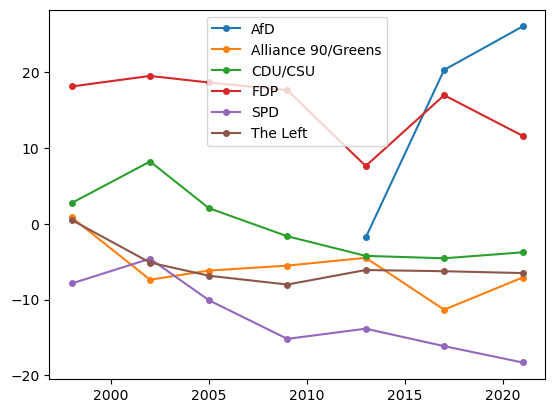

In [12]:
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in d2v_germany.groupby('party_name'):
    ax.plot(group.election, group.d2v_d1, marker='o',  ms=4, label=name)
ax.legend()

plt.show()

In [37]:
df_d2v.to_csv('data/py_outputs/r&c_gen.csv', index=False)

## Doc2Vec scaling - relevant topics
 

In [18]:
set(manifesto_d2v['topic'])

{'Agriculture - Protectionism',
 'Economics',
 'Education',
 'Environment - Growth',
 'European Integration',
 'Fabrics of Society',
 'Immigration',
 'International Relations',
 'Labour and Social Welfare',
 'Military',
 'Other',
 'Political System'}

In [20]:
# Create an empty list to store the country-topic level dataframes
country_topic_dfs = []

# Get the unique list of countries from your data
unique_countries = manifesto_d2v['countryname'].unique()

# Loop through each country
for country in unique_countries:
    print(f"Processing country: {country}")
    
    # Filter the dataset for the current country
    country_data = manifesto_d2v[manifesto_d2v['countryname'] == country]
    country_data = country_data[country_data['topic'].isin(['Environment - Growth', 'Political System', 'Economics',
                                                            'European Integration','Labour and Social Welfare',
                                                            'Immigration'])]
    # Get the unique list of topics within this country
    unique_topics = country_data['topic'].unique()
    
    # Loop through each topic in the country
    for topic in unique_topics:
        print(f"Processing topic: {topic}")

        # Filter the dataset for the current country and topic
        country_topic_data = country_data[country_data['topic'] == topic]

        # Build the corpus iterator for this country's topic-specific data
        outputs_stream = phraseIterator(country_topic_data, 'text_cleaned')
        bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
        trigram = Phrases(bigram[outputs_stream], min_count=1, threshold=5)

        # Create the Doc2Vec model and build vocabulary
        model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
        model.build_vocab(corpusIterator(country_topic_data, bigram=bigram, trigram=trigram, text='text_cleaned', labels='party_election'))

        # Train the model
        model.train(corpusIterator(country_topic_data, bigram=bigram, trigram=trigram, text='text_cleaned', labels='party_election'),
                    total_examples=model.corpus_count, epochs=20)

        # Generate embeddings and apply dimensionality reduction
        embed_dict = d2v_reduct(model)
        df_d2v = pd.DataFrame.from_dict(embed_dict).transpose()
        df_d2v.index.name = 'party_election'
        df_d2v.reset_index(inplace=True)
        pca = PCA(n_components=2, random_state=seed_val)
        df_d2v[['d2v_d1', 'd2v_d2']] = pca.fit_transform(df_d2v.iloc[:, 1:])
        df_d2v = df_d2v[['party_election', 'd2v_d1', 'd2v_d2']]

        # Split the 'party_election' label into separate columns
        df_d2v[['party', 'election']] = df_d2v['party_election'].str.split('_', expand=True)
        df_d2v.loc[:, 'election'] = df_d2v['election'].astype(int)
        df_d2v['country'] = country  # Add country column
        df_d2v['topic'] = topic  # Add topic column

        # Append the country-topic-level dataframe to the list
        country_topic_dfs.append(df_d2v)

# Merge all country-topic-level datasets into a single dataframe
final_df_d2v = pd.concat(country_topic_dfs, ignore_index=True)

# Save the final dataframe to a CSV file
final_df_d2v.to_csv('data/py_outputs/r&c_party_election_topic.csv', index=False)

# Print a summary
print(final_df_d2v.info())


Processing country: Sweden
Processing topic: Economics
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Processing topic: Political System
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Processing topic: Labour and Social Welfare
Starting new epoch
Starting new epoch
Starting new epoch
Starting ne

## Doc2Vec scaling - Environment Protection
 

In [22]:
manifesto_ep = manifesto_d2v[manifesto_d2v.cmp_code.isin(['501'])].reset_index(drop=True)


In [23]:
manifesto_ep.head()

,text,text_en,cmp_code,eu_code,pos,manifesto_id,party,date,language,source,...,abbrev,name,edate,parfam,sentiment,topic,election,text_cleaned,party_election,country_party_election
0,och ett långsiktigt miljöansvar.,and long-term environmental responsibility.,501,NaN,5,11110_200609,11110,200609,swedish,MARPOR,...,MP,Miljöpartiet de Gröna,17/09/2006,10,left,Environment - Growth,2006,långsiktigt miljöansvar,11110_2006,Sweden_11110_2006
1,Vår politik kombinerar en grön omställning,Our policies combine a green transition,501,NaN,6,11110_200609,11110,200609,swedish,MARPOR,...,MP,Miljöpartiet de Gröna,17/09/2006,10,left,Environment - Growth,2006,politik kombinerar grön omställning,11110_2006,Sweden_11110_2006
2,"solidaritet med djur, natur och det ekologiska...","with animals, nature and the ecological system...",501,NaN,13,11110_200609,11110,200609,swedish,MARPOR,...,MP,Miljöpartiet de Gröna,17/09/2006,10,left,Environment - Growth,2006,solidaritet djur natur ekologiska systemet,11110_2006,Sweden_11110_2006
3,Vi vill att Sveriges beroende av olja och andr...,We want to break Sweden's dependence on oil an...,501,NaN,19,11110_200609,11110,200609,swedish,MARPOR,...,MP,Miljöpartiet de Gröna,17/09/2006,10,left,Environment - Growth,2006,vill sveriges beroende olja andra fossila brän...,11110_2006,Sweden_11110_2006
4,och hus byggas energisnålt.,and houses are built in an energy-efficient way.,501,NaN,22,11110_200609,11110,200609,swedish,MARPOR,...,MP,Miljöpartiet de Gröna,17/09/2006,10,left,Environment - Growth,2006,hus byggas energisnålt,11110_2006,Sweden_11110_2006


In [25]:
# Create an empty list to store the country-level dataframes
country_dfs = []

# Get the unique list of countries from your data
unique_countries = manifesto_ep['countryname'].unique()

# Loop through each country and process separately
for country in unique_countries:
    print(f"Processing country: {country}")
    
    # Filter the dataset for the current country
    country_data = manifesto_ep[manifesto_ep['countryname'] == country]
    
    # Build the corpus iterator for this country's data
    outputs_stream = phraseIterator(country_data, 'text_cleaned')
    bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
    trigram = Phrases(bigram[outputs_stream], min_count=1, threshold=5)
    
    # Create the Doc2Vec model and build vocabulary
    model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
    model.build_vocab(corpusIterator(country_data, bigram=bigram, trigram=trigram, text='text_cleaned', labels='party_election'))
    
    # Train the model
    model.train(corpusIterator(country_data, bigram=bigram, trigram=trigram, text='text_cleaned', labels='party_election'),
                total_examples=model.corpus_count, epochs=20)
    
    # Generate embeddings and apply dimensionality reduction
    embed_dict = d2v_reduct(model)
    df_d2v = pd.DataFrame.from_dict(embed_dict).transpose()
    df_d2v.index.name = 'party_election'
    df_d2v.reset_index(inplace=True)
    pca = PCA(n_components=2, random_state=seed_val)
    df_d2v[['d2v_d1', 'd2v_d2']] = pca.fit_transform(df_d2v.iloc[:, 1:])
    df_d2v = df_d2v[['party_election', 'd2v_d1', 'd2v_d2']]
    
    # Split the 'party_election' label into separate columns
    df_d2v[['party', 'election']] = df_d2v['party_election'].str.split('_', expand=True)
    df_d2v.loc[:, 'election'] = df_d2v['election'].astype(int)
    df_d2v['country'] = country  # Add country column for merging later
    
    # Append the country-level dataframe to the list
    country_dfs.append(df_d2v)

# Merge all country-level datasets into a single dataframe
final_df_d2v = pd.concat(country_dfs, ignore_index=True)

# Save the final dataframe to a CSV file
final_df_d2v.to_csv('data/py_outputs/r&c_ep_party_election.csv', index=False)

# Print a summary
print(final_df_d2v.info())


Processing country: Sweden
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Processing country: Norway
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Processing country: Denmark
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starti

## Doc2Vec scaling - Germany, growth vs anti growth
 

In [9]:
manifesto_welfare = manifesto_d2v[manifesto_d2v.cmp_code.isin(['504', '505'])].reset_index(drop=True)


In [10]:
manifesto_welfare.head()

,text,text_en,cmp_code,eu_code,pos,manifesto_id,party,date,language,source,...,abbrev,name,edate,parfam,sentiment,topic,election,text_cleaned,party_election,country_party_election
0,nya livschanser,new life chances,504,NaN,4,11110_200609,11110,200609,swedish,MARPOR,...,MP,Miljöpartiet de Gröna,17/09/2006,10,left,Labour and Social Welfare,2006,nya livschanser,11110_2006,Sweden_11110_2006
1,Det finns behov av och utrymme för fler anstäl...,There is a need and room for more employees in...,504,NaN,31,11110_200609,11110,200609,swedish,MARPOR,...,MP,Miljöpartiet de Gröna,17/09/2006,10,left,Labour and Social Welfare,2006,finns behov utrymme fler anställda offentligt ...,11110_2006,Sweden_11110_2006
2,Vi vill överföra pengar från arbetsmarknadsåtg...,We want to transfer money from labor market me...,504,NaN,32,11110_200609,11110,200609,swedish,MARPOR,...,MP,Miljöpartiet de Gröna,17/09/2006,10,left,Labour and Social Welfare,2006,vill överföra pengar arbetsmarknadsåtgärder an...,11110_2006,Sweden_11110_2006
3,"sjukvården,","healthcare,",504,NaN,35,11110_200609,11110,200609,swedish,MARPOR,...,MP,Miljöpartiet de Gröna,17/09/2006,10,left,Labour and Social Welfare,2006,sjukvården,11110_2006,Sweden_11110_2006
4,äldreomsorgen,elderly care,504,NaN,36,11110_200609,11110,200609,swedish,MARPOR,...,MP,Miljöpartiet de Gröna,17/09/2006,10,left,Labour and Social Welfare,2006,äldreomsorgen,11110_2006,Sweden_11110_2006


In [11]:
# Create an empty list to store the country-level dataframes
country_dfs = []

# Get the unique list of countries from your data
unique_countries = manifesto_welfare['countryname'].unique()

# Loop through each country and process separately
for country in unique_countries:
    print(f"Processing country: {country}")
    
    # Filter the dataset for the current country
    country_data = manifesto_welfare[manifesto_welfare['countryname'] == country]
    
    # Build the corpus iterator for this country's data
    outputs_stream = phraseIterator(country_data, 'text_cleaned')
    bigram = Phraser(Phrases(outputs_stream, min_count=1, threshold=5))
    trigram = Phrases(bigram[outputs_stream], min_count=1, threshold=5)
    
    # Create the Doc2Vec model and build vocabulary
    model = Doc2Vec(vector_size=500, window=6, min_count=1, workers=16, epochs=20, seed=seed_val)
    model.build_vocab(corpusIterator(country_data, bigram=bigram, trigram=trigram, text='text_cleaned', labels='party_election'))
    
    # Train the model
    model.train(corpusIterator(country_data, bigram=bigram, trigram=trigram, text='text_cleaned', labels='party_election'),
                total_examples=model.corpus_count, epochs=20)
    
    # Generate embeddings and apply dimensionality reduction
    embed_dict = d2v_reduct(model)
    df_d2v = pd.DataFrame.from_dict(embed_dict).transpose()
    df_d2v.index.name = 'party_election'
    df_d2v.reset_index(inplace=True)
    pca = PCA(n_components=2, random_state=seed_val)
    df_d2v[['d2v_d1', 'd2v_d2']] = pca.fit_transform(df_d2v.iloc[:, 1:])
    df_d2v = df_d2v[['party_election', 'd2v_d1', 'd2v_d2']]
    
    # Split the 'party_election' label into separate columns
    df_d2v[['party', 'election']] = df_d2v['party_election'].str.split('_', expand=True)
    df_d2v.loc[:, 'election'] = df_d2v['election'].astype(int)
    df_d2v['country'] = country  # Add country column for merging later
    
    # Append the country-level dataframe to the list
    country_dfs.append(df_d2v)

# Merge all country-level datasets into a single dataframe
final_df_d2v = pd.concat(country_dfs, ignore_index=True)

# Save the final dataframe to a CSV file
final_df_d2v.to_csv('data/py_outputs/r&c_welfare_party_election.csv', index=False)

# Print a summary
print(final_df_d2v.info())


Processing country: Sweden
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Processing country: Norway
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Processing country: Denmark
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starting new epoch
Starti

# Scale position scores for all countries (released dataset + model)

## Retrain for the entire dataset with all languages

In [5]:
manifesto_org = pd.read_csv(os.path.join("data", "r_outputs","pulled_manifestoes.csv"), encoding="utf-8", dtype={2:'str',18:'str'})

In [6]:
manifesto_other = pd.read_csv(os.path.join("data", "r_outputs","pulled_manifestoes_test.csv"), encoding="utf-8", dtype={2:'str',18:'str'})

In [7]:
manifesto_org_cleaned = manifesto_org.dropna(axis=1, how='all')
manifesto_other_cleaned = manifesto_other.dropna(axis=1, how='all')
manifesto_full = pd.concat([manifesto_org_cleaned, manifesto_other_cleaned]).reset_index(drop=True)

In [7]:
manifesto_full.head()

,text,text_en,cmp_code,eu_code,pos,manifesto_id,party,date,language,source,...,title,translation_en,id,country,party_code,countryname,abbrev,name,edate,parfam
0,Miljöpartiet de Gröna går till val på en polit...,The Green Party is running on a policy for mor...,408,NaN,1,11110_200609,11110,200609,swedish,MARPOR,...,Valmanifest 2006. Grönare Sverige! – för ökad ...,True,11110_200609,11,11110,Sweden,MP,Miljöpartiet de Gröna,17/09/2006,10.0
1,"fler företag,","more businesses, a",402,NaN,2,11110_200609,11110,200609,swedish,MARPOR,...,Valmanifest 2006. Grönare Sverige! – för ökad ...,True,11110_200609,11,11110,Sweden,MP,Miljöpartiet de Gröna,17/09/2006,10.0
2,"levande landsbygd,","vibrant countryside,",301,NaN,3,11110_200609,11110,200609,swedish,MARPOR,...,Valmanifest 2006. Grönare Sverige! – för ökad ...,True,11110_200609,11,11110,Sweden,MP,Miljöpartiet de Gröna,17/09/2006,10.0
3,nya livschanser,new life chances,504,NaN,4,11110_200609,11110,200609,swedish,MARPOR,...,Valmanifest 2006. Grönare Sverige! – för ökad ...,True,11110_200609,11,11110,Sweden,MP,Miljöpartiet de Gröna,17/09/2006,10.0
4,och ett långsiktigt miljöansvar.,and long-term environmental responsibility.,501,NaN,5,11110_200609,11110,200609,swedish,MARPOR,...,Valmanifest 2006. Grönare Sverige! – för ökad ...,True,11110_200609,11,11110,Sweden,MP,Miljöpartiet de Gröna,17/09/2006,10.0


In [8]:
len(manifesto_full)

1030129

In [8]:
manifesto_full = manifesto_full[(manifesto_full.cmp_code.notna()) & ~(manifesto_full.cmp_code == 'H')].reset_index(drop=True)

In [9]:
manifesto_full['sentiment'] = manifesto_full['cmp_code'].apply(sentiment_code)
manifesto_full['topic'] = manifesto_full['cmp_code'].apply(topic_code)
manifesto_full['election'] = manifesto_full['date'].astype(str).str[:4]

In [11]:
manifesto_full.groupby('sentiment').count()

,text,text_en,cmp_code,eu_code,pos,manifesto_id,party,date,language,source,...,id,country,party_code,countryname,abbrev,name,edate,parfam,topic,election
sentiment,,,,,,,,,,,,,,,,,,,,,
left,498722,441871,498722,491,498722,498722,498722,498722,498722,459916,...,459916,498722,498722,495031,467230,495031,495031,495031,498722,498722
neutral,271060,230575,271060,208,271060,271060,271060,271060,271060,240526,...,240526,271060,271060,269746,254848,269746,269746,269746,271060,271060
right,205496,175872,205496,462,205496,205496,205496,205496,205496,182881,...,182881,205496,205496,204199,196171,204199,204199,204199,205496,205496


In [12]:
manifesto_full.groupby(['topic'])['sentiment'].value_counts().unstack(fill_value=0)

sentiment,left,neutral,right
topic,,,
Agriculture - Protectionism,22929,0,2506
Economics,58507,86154,44805
Education,49656,0,662
Environment - Growth,67767,21287,14133
European Integration,14662,0,6240
Fabrics of Society,39173,19394,57744
Immigration,12906,0,20398
International Relations,27241,3776,2441
Labour and Social Welfare,198438,4396,6782


In [10]:
results = group_texts(manifesto_full, 
                      ['countryname','election','party','cmp_code'], 'text', 
                      max_group_factor = 5)

In [11]:
manifesto_regrouped = pd.DataFrame(results)
manifesto_regrouped = manifesto_regrouped.explode('text').reset_index(drop=True)

In [12]:
df_cols = manifesto_regrouped['labels'].str.split(';', expand=True)
manifesto_regrouped = pd.concat([manifesto_regrouped, df_cols], axis=1)


In [13]:
manifesto_regrouped.columns = ['text', 'country_election_party_code', 'country','election', 'party', 'cmp_code']

In [17]:
manifesto_regrouped.head()

,text,country_election_party_code,country,election,party,cmp_code
0,Statt dessen soll ein Freiwilligen-Milizheer g...,Austria;1999;42110;104,Austria,1999,42110,104
1,"Weg von der Sicherheit durch Rüstung, Unsere S...",Austria;1999;42110;105,Austria,1999,42110,105
2,Die Militarisierung der EU bringt mehr Rüstung...,Austria;1999;42110;105,Austria,1999,42110,105
3,Bei einem Beitritt Österreichs könnten auch ös...,Austria;1999;42110;105,Austria,1999,42110,105
4,Seit 2 Jahren werden 500 Panzer für das österr...,Austria;1999;42110;105,Austria,1999,42110,105


In [14]:
manifesto_regrouped.loc[:,'sentiment'] = manifesto_regrouped['cmp_code'].apply(sentiment_code)
manifesto_regrouped.loc[:,'topic'] = manifesto_regrouped['cmp_code'].apply(topic_code)
manifesto_regrouped = manifesto_regrouped.drop_duplicates().reset_index(drop=True)
 

In [19]:
manifesto_regrouped.head()

,text,country_election_party_code,country,election,party,cmp_code,sentiment,topic
0,Statt dessen soll ein Freiwilligen-Milizheer g...,Austria;1999;42110;104,Austria,1999,42110,104,right,Military
1,"Weg von der Sicherheit durch Rüstung, Unsere S...",Austria;1999;42110;105,Austria,1999,42110,105,left,Military
2,Die Militarisierung der EU bringt mehr Rüstung...,Austria;1999;42110;105,Austria,1999,42110,105,left,Military
3,Bei einem Beitritt Österreichs könnten auch ös...,Austria;1999;42110;105,Austria,1999,42110,105,left,Military
4,Seit 2 Jahren werden 500 Panzer für das österr...,Austria;1999;42110;105,Austria,1999,42110,105,left,Military


In [20]:
manifesto_regrouped.to_csv('data/temps/manifesto_regrouped_full_processed.csv', encoding='utf-8', index=False)
manifesto_full.to_csv('data/temps/manifesto_full_processed.csv', encoding='utf-8', index=False)

In [15]:
coalition_regrouped = pd.read_csv('data/temps/coalitionagree_regrouped_processed.csv', encoding='utf-8')

In [16]:
manifesto_regrouped.loc[:, 'source'] = 'manifestos'
coalition_regrouped.loc[:, 'source'] = 'coalition_contracts'

In [17]:
coalition_regrouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39287 entries, 0 to 39286
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       39287 non-null  object
 1   labels     39287 non-null  object
 2   country    39287 non-null  object
 3   year       39287 non-null  int64 
 4   cmp_short  39287 non-null  int64 
 5   cmp_long   39287 non-null  int64 
 6   sentiment  39287 non-null  object
 7   topic      39287 non-null  object
 8   source     39287 non-null  object
dtypes: int64(3), object(6)
memory usage: 2.7+ MB


In [24]:
coalition_regrouped.groupby(['topic'])['sentiment'].value_counts().unstack(fill_value=0)

sentiment,left,neutral,right
topic,,,
Agriculture - Protectionism,877,0,86
Economics,2025,3564,2592
Education,1883,0,37
Environment - Growth,2045,337,754
European Integration,862,0,90
Fabrics of Society,831,769,2115
Immigration,485,0,429
International Relations,1236,202,36
Labour and Social Welfare,6767,30,502


In [18]:
final_df = pd.concat([manifesto_regrouped[['text','sentiment','topic', 'source']], coalition_regrouped[['text','sentiment','topic','source']]]).reset_index(drop=True)

In [19]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

In [20]:
final_df.loc[:,'topic_sentiment'] = final_df['topic'] + '_' + final_df['sentiment']

In [21]:
final_dataset = Dataset.from_pandas(final_df)
final_dataset = final_dataset.class_encode_column('sentiment')
final_dataset = final_dataset.class_encode_column('topic')
final_dataset = final_dataset.class_encode_column('topic_sentiment')
final_dataset = final_dataset.class_encode_column('source')



Casting to class labels:   0%|          | 0/409042 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/409042 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/409042 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/409042 [00:00<?, ? examples/s]

In [22]:
train_test = final_dataset.train_test_split(test_size=0.1, stratify_by_column='topic_sentiment', seed=seed_val)

In [23]:
final_datasets = DatasetDict({
    'train': train_test['train'],
    'test': train_test['test']
})
final_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'sentiment', 'topic', 'source', 'topic_sentiment'],
        num_rows: 368137
    })
    test: Dataset({
        features: ['text', 'sentiment', 'topic', 'source', 'topic_sentiment'],
        num_rows: 40905
    })
})

In [24]:
tokenized_datasets = final_datasets.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 512}, 
                                            remove_columns=['text','topic_sentiment'])
tokenized_datasets.set_format("torch")
tokenized_datasets.column_names

Map:   0%|          | 0/368137 [00:00<?, ? examples/s]

Map:   0%|          | 0/40905 [00:00<?, ? examples/s]

{'train': ['sentiment', 'topic', 'source', 'input_ids', 'attention_mask'],
 'test': ['sentiment', 'topic', 'source', 'input_ids', 'attention_mask']}

In [25]:
train_dataloader = DataLoader(tokenized_datasets['train'], batch_size=16, shuffle=True, collate_fn = data_collator)
test_dataloader = DataLoader(tokenized_datasets['test'], batch_size=16, shuffle=False, collate_fn = data_collator)


In [26]:
num_topics = len(set(final_df['topic']))
num_sentiments = len(set(final_df['sentiment']))
model = ContextScalePrediction(roberta_model=model_name, num_topics=12, num_sentiments=3,lora=False, use_shared_attention=True).to(device)



In [27]:
n_epochs=5
total_steps = len(train_dataloader)*n_epochs
warmup = total_steps*0.1
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5) ## Recommended for LoRA. Without LoRA, can use 2e-5 instead.
scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps=total_steps, num_warmup_steps=warmup)
criterion = nn.CrossEntropyLoss()

In [28]:
for epoch in range(n_epochs):
    print(f"Epoch: {epoch+1}")
    train_loop(train_dataloader, model,optimizer, scheduler, device, criterion, criterion, sentiment_var='sentiment',
               topic_var='topic')

Epoch: 1

Training...
Batch 100: loss=3.759544, elapsed=12.99s, remaining=2850.86s.
Batch 200: loss=3.699653, elapsed=24.18s, remaining=2654.37s.
Batch 300: loss=3.643533, elapsed=35.06s, remaining=2557.49s.
Batch 400: loss=3.581381, elapsed=45.60s, remaining=2486.90s.
Batch 500: loss=3.525105, elapsed=56.21s, remaining=2443.31s.
Batch 600: loss=3.484221, elapsed=66.85s, remaining=2411.37s.
Batch 700: loss=3.436211, elapsed=77.69s, remaining=2391.76s.
Batch 800: loss=3.375388, elapsed=88.79s, remaining=2380.93s.
Batch 900: loss=3.299624, elapsed=99.91s, remaining=2369.78s.
Batch 1000: loss=3.218033, elapsed=110.86s, remaining=2355.73s.
Batch 1100: loss=3.138289, elapsed=121.73s, remaining=2341.01s.
Batch 1200: loss=3.064908, elapsed=132.28s, remaining=2320.46s.
Batch 1300: loss=2.989242, elapsed=143.56s, remaining=2313.28s.
Batch 1400: loss=2.923838, elapsed=154.63s, remaining=2302.43s.
Batch 1500: loss=2.862984, elapsed=165.20s, remaining=2285.21s.
Batch 1600: loss=2.808982, elapsed=1

In [29]:
state_dict = model.state_dict()
save_file(state_dict, 'results/models/contextscale_full_released/model.safetensors')

## Scale manifestos and coalition contracts

In [30]:
coalition_regrouped = pd.read_csv('data/temps/coalitionagree_regrouped_processed.csv', encoding='utf-8')
manifesto_regrouped = pd.read_csv('data/temps/manifesto_regrouped_full_processed.csv', encoding='utf-8')

In [31]:
model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer)

In [35]:
num_topics = 12
num_sentiments = 3
scaling_model = ContextScalePrediction(roberta_model=model_name, num_topics=12, num_sentiments=3,lora=False, use_shared_attention=True).to(device)

model=None

In [36]:
loaded_tensors = load_file('results/models/contextscale_full_released/model.safetensors')
scaling_model.load_state_dict(loaded_tensors)

<All keys matched successfully>

In [37]:
manifesto_dataset = Dataset.from_pandas(manifesto_regrouped[['text','topic','sentiment']].copy())
coalition_dataset = Dataset.from_pandas(coalition_regrouped[['text','topic','sentiment']].copy())
manifesto_dataset = manifesto_dataset.class_encode_column('topic') 
coalition_dataset = coalition_dataset.class_encode_column('topic')
manifesto_dataset = manifesto_dataset.class_encode_column('sentiment') 
coalition_dataset = coalition_dataset.class_encode_column('sentiment')

Casting to class labels:   0%|          | 0/369755 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/369755 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/39287 [00:00<?, ? examples/s]

In [38]:
tokenized_manifesto_dataset = manifesto_dataset.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 512}, 
                                            remove_columns=['text'])
tokenized_manifesto_dataset.set_format("torch")
tokenized_coalition_dataset = coalition_dataset.map(tokenize_function, 
                                            fn_kwargs={'tokenizer': tokenizer, 'text_var': 'text', 'max_length': 512}, 
                                            remove_columns=['text'])
tokenized_coalition_dataset.set_format("torch")


Map:   0%|          | 0/369755 [00:00<?, ? examples/s]

Map:   0%|          | 0/39287 [00:00<?, ? examples/s]

In [39]:
manifesto_dataloader = DataLoader(tokenized_manifesto_dataset, batch_size=16, shuffle=False, collate_fn= data_collator)
coalition_dataloader = DataLoader(tokenized_coalition_dataset, batch_size=16, shuffle=False, collate_fn=data_collator)

In [41]:
## Compute position scores
output_manifesto_final = scale_func(manifesto_dataloader, 
               scaling_model, 
               device, 
               topic_label='topic', 
               sentiment_label='sentiment', 
               timing_log=True,
               use_ground_truth_topic=True)

Start predicting labels...
Labels for topic are provided. They will be used for position scaling!
Elapsed time: 33.80s, Estimated remaining time: 747.32s
Elapsed time: 76.53s, Estimated remaining time: 807.79s
Elapsed time: 117.62s, Estimated remaining time: 788.42s
Elapsed time: 158.99s, Estimated remaining time: 759.55s
Elapsed time: 200.20s, Estimated remaining time: 725.12s
Elapsed time: 231.22s, Estimated remaining time: 659.36s
Elapsed time: 265.45s, Estimated remaining time: 610.91s
Elapsed time: 298.23s, Estimated remaining time: 563.28s
Elapsed time: 342.40s, Estimated remaining time: 536.81s
Elapsed time: 379.39s, Estimated remaining time: 497.38s
Elapsed time: 423.42s, Estimated remaining time: 466.14s
Elapsed time: 457.57s, Estimated remaining time: 423.64s
Elapsed time: 488.36s, Estimated remaining time: 379.80s
Elapsed time: 519.08s, Estimated remaining time: 337.77s
Elapsed time: 549.56s, Estimated remaining time: 297.13s
Elapsed time: 582.32s, Estimated remaining time: 

In [42]:
file_path = 'data/temps/topic_labels'
with open(file_path, 'rb') as fp:
    topic_labels = pickle.load(fp)
name_topic_dict = dict([(x,y) for x,y in enumerate(topic_labels)])


file_path = 'data/temps/sentiment_labels'
with open(file_path, 'rb') as fp:
    sentiment_labels = pickle.load(fp)
name_sentiment_dict = dict([(x,y) for x,y in enumerate(sentiment_labels)])



In [44]:
output_manifesto_final.keys()

dict_keys(['res_table_topic', 'res_table_sentiment', 'position_scores', 'pred_topics', 'pred_sentiment', 'total_time', 'avg_batch_time'])

In [49]:
manifesto_regrouped.loc[:,'position_scores'] = output_manifesto_final['position_scores'].flatten()
manifesto_regrouped.loc[:,'pred_sentiment'] = output_manifesto_final['pred_sentiment']
manifesto_regrouped.loc[:,'pred_sentiment_name'] = manifesto_regrouped.pred_sentiment.map(name_sentiment_dict)

In [50]:
manifesto_regrouped.head()

,text,country_election_party_code,country,election,party,cmp_code,sentiment,topic,position_scores,pred_sentiment,pred_sentiment_name
0,Statt dessen soll ein Freiwilligen-Milizheer g...,Austria;1999;42110;104,Austria,1999,42110,104.0,right,Military,0.858892,2,right
1,"Weg von der Sicherheit durch Rüstung, Unsere S...",Austria;1999;42110;105,Austria,1999,42110,105.0,left,Military,-0.854351,0,left
2,Die Militarisierung der EU bringt mehr Rüstung...,Austria;1999;42110;105,Austria,1999,42110,105.0,left,Military,-0.671753,0,left
3,Bei einem Beitritt Österreichs könnten auch ös...,Austria;1999;42110;105,Austria,1999,42110,105.0,left,Military,-0.819007,0,left
4,Seit 2 Jahren werden 500 Panzer für das österr...,Austria;1999;42110;105,Austria,1999,42110,105.0,left,Military,-0.767466,0,left


In [51]:
manifesto_regrouped.to_csv('results/datasets/manifesto_full_scaled.csv', encoding='utf-8', index=False)

In [54]:
## Compute position scores
output_coalition_final = scale_func(coalition_dataloader, 
               scaling_model, 
               device, 
               topic_label='topic', 
               sentiment_label='sentiment', 
               timing_log=True,
               use_ground_truth_topic=True)

Start predicting labels...
Labels for topic are provided. They will be used for position scaling!
Elapsed time: 43.16s, Estimated remaining time: 62.85s
Elapsed time: 79.96s, Estimated remaining time: 18.23s
Start computing position scores


In [55]:
coalition_regrouped.loc[:,'position_scores'] = output_coalition_final['position_scores'].flatten()
coalition_regrouped.loc[:,'pred_sentiment'] = output_coalition_final['pred_sentiment']
coalition_regrouped.loc[:,'pred_sentiment_name'] = coalition_regrouped.pred_sentiment.map(name_topic_dict)

In [56]:
coalition_regrouped.to_csv('results/datasets/coalition_full_scaled.csv', encoding='utf-8', index=False)

## Create released dataset (position scores by country-party-election)

In [57]:
columns  =['country','party', 'election','topic','cs_mean_score', 'cs_se_score']
df = pd.DataFrame(columns=columns)

for name, group in manifesto_regrouped.groupby(['country','party','election','topic']):
    mean_score = group['position_scores'].mean()
    se_score = group['position_scores'].std()/np.sqrt(len(group))
    df_temp = pd.DataFrame([[str(group.iloc[0,group.columns.get_loc('country')]),
                             str(group.iloc[0,group.columns.get_loc('party')]), 
                    str(group.iloc[0,group.columns.get_loc('election')]), 
                    str(group.iloc[0,group.columns.get_loc('topic')]),
               mean_score, se_score]], columns = columns)
    df = (df_temp if df.empty else pd.concat([df, df_temp], ignore_index=True))

In [58]:
df.to_csv('results/datasets/contextscale_manifesto_dataset.csv', encoding='utf-8')

In [59]:
df.head()

,country,party,election,topic,cs_mean_score,cs_se_score
0,Austria,42110,1999,Agriculture - Protectionism,-0.884188,NaN
1,Austria,42110,1999,Economics,0.025536,0.105402
2,Austria,42110,1999,Education,-0.877355,0.017827
3,Austria,42110,1999,Environment - Growth,-0.535783,0.056544
4,Austria,42110,1999,European Integration,-0.531903,0.111941


In [60]:
columns  =['country', 'year','topic','cs_mean_score', 'cs_se_score']
df = pd.DataFrame(columns=columns)

for name, group in coalition_regrouped.groupby(['country','year','topic']):
    mean_score = group['position_scores'].mean()
    se_score = group['position_scores'].std()/np.sqrt(len(group))
    df_temp = pd.DataFrame([[str(group.iloc[0,group.columns.get_loc('country')]),
                    str(group.iloc[0,group.columns.get_loc('year')]), 
                    str(group.iloc[0,group.columns.get_loc('topic')]),
               mean_score, se_score]], columns = columns)
    df = (df_temp if df.empty else pd.concat([df, df_temp], ignore_index=True))

In [62]:
df.head()

,country,year,topic,cs_mean_score,cs_se_score
0,Austria,1945,Economics,-0.687361,NaN
1,Austria,1945,Education,-0.923366,NaN
2,Austria,1945,Other,-0.025228,0.017780
3,Austria,1945,Political System,0.051062,0.095684
4,Austria,1949,Agriculture - Protectionism,-0.909265,0.009542


In [61]:
df.to_csv('results/datasets/contextscale_coalition_dataset.csv', encoding='utf-8')

# Deep Ensemble Training and Uncertainty Estimation

This section implements deep ensemble training with uncertainty estimation using the redesigned exponential position score computation.

In [14]:
# Import the new uncertainty module
import sys
sys.path.append('utils/')
from uncertainty import (
    compute_position_score_exponential, 
    train_deep_ensemble, 
    ensemble_inference,
    load_ensemble_models,
    save_ensemble_results,
    create_ensemble_summary_dataframe
)

## Configuration Parameters

In [15]:
# Configuration for ensemble training and uncertainty estimation
ENSEMBLE_CONFIG = {
    'num_models': 5,  # Number of ensemble members
    'beta': 1.0,      # Beta parameter for exponential position score
    'n_epochs': 5,    # Epochs per model
    'lr': 2e-5,       # Learning rate
    'save_dir': 'results/models/ensemble',
    'model_prefix': 'model_ensemble'
}

print("Ensemble Configuration:")
for key, value in ENSEMBLE_CONFIG.items():
    print(f"  {key}: {value}")

Ensemble Configuration:
  num_models: 5
  beta: 1.0
  n_epochs: 5
  lr: 2e-05
  save_dir: results/models/ensemble
  model_prefix: model_ensemble


## Define model



In [16]:
# Define model factory function for ensemble training

num_topics = len(set(manifesto_dataset['topic']))
num_sentiments = len(set(manifesto_dataset['sentiment']))
def create_model():
    """Factory function to create a new model instance for ensemble training."""
    return ContextScalePrediction(
        roberta_model=model_name, 
        num_topics=num_topics, 
        num_sentiments=num_sentiments,
        lora=True,
        use_shared_attention=True  # Using shared attention architecture
    )

print("Model factory function defined")

Model factory function defined


## Creating Multiple Data Splits for Ensemble Training

Instead of using the same train/eval/test split with different shuffles, we'll create 5 completely different splits from the original dataset. This provides much better diversity for ensemble training and more robust uncertainty estimation.

In [17]:
# Import the updated uncertainty module with multiple splits functionality
from uncertainty import create_multiple_data_splits, train_deep_ensemble

# Create 5 different train/eval/test splits from the original dataset
print("Creating 5 different data splits from the original dataset...")
print("Each split will have different train/eval/test samples for better ensemble diversity")

data_splits = create_multiple_data_splits(
    original_dataset=manifesto_dataset,
    num_splits=5,
    test_size=0.1,  # 10% for test
    eval_size=0.3,  # 30% of remaining data for eval
    stratify_column='topic_sentiment',
    base_seed=seed_val
)

print(f"\nSuccessfully created {len(data_splits)} different data splits!")
print("Summary of splits:")
for i, split in enumerate(data_splits):
    print(f"Split {i+1}: Train={len(split['train'])}, Eval={len(split['eval'])}, Test={len(split['test'])}, Seed={split['seed']}")

Creating 5 different data splits from the original dataset...
Each split will have different train/eval/test samples for better ensemble diversity
Creating data split 1/5 with seed 1234
Split 1: Train=212569, Eval=91101, Test=33742
Creating data split 2/5 with seed 2234
Split 1: Train=212569, Eval=91101, Test=33742
Creating data split 2/5 with seed 2234
Split 2: Train=212569, Eval=91101, Test=33742
Creating data split 3/5 with seed 3234
Split 2: Train=212569, Eval=91101, Test=33742
Creating data split 3/5 with seed 3234
Split 3: Train=212569, Eval=91101, Test=33742
Creating data split 4/5 with seed 4234
Split 3: Train=212569, Eval=91101, Test=33742
Creating data split 4/5 with seed 4234
Split 4: Train=212569, Eval=91101, Test=33742
Creating data split 5/5 with seed 5234
Split 4: Train=212569, Eval=91101, Test=33742
Creating data split 5/5 with seed 5234
Split 5: Train=212569, Eval=91101, Test=33742

Successfully created 5 different data splits!
Summary of splits:
Split 1: Train=212569,

## Deep Ensemble Training with Different Data Splits

Now let's train the ensemble using the different data splits instead of just shuffling the same split.

In [18]:
# Train the deep ensemble with different data splits
print("Starting Deep Ensemble Training with Different Data Splits")
print("This will train {} models using completely different train/eval/test splits".format(len(data_splits)))
print("Each model will be trained for {} epochs".format(ENSEMBLE_CONFIG['n_epochs']))
print("This approach provides much better diversity than shuffling the same split")

ensemble_info_splits = train_deep_ensemble(
    model_factory=create_model,
    data_splits=data_splits,
    tokenizer=tokenizer,
    data_collator=data_collator,
    device=device,
    batch_size=16,
    n_epochs=ENSEMBLE_CONFIG['n_epochs'],
    lr=ENSEMBLE_CONFIG['lr'],
    sentiment_var='sentiment',
    topic_var='topic',
    save_dir=ENSEMBLE_CONFIG['save_dir'] + '_splits',  # Different directory
    model_prefix=ENSEMBLE_CONFIG['model_prefix'] + '_splits',
    org_seed=seed_val
)

print("Ensemble training with different splits completed!")
print(f"Total models trained: {len(ensemble_info_splits)}")
print("Each model was trained with:")
print("  - Different random seed (42 + model_id)")
print("  - Completely different train/eval/test data split") 
print("  - Same model architecture and hyperparameters")
for i, info in enumerate(ensemble_info_splits):
    total_time = sum(info['train_times'])
    print(f"Model {i}: Total training time = {total_time:.1f}s, Split seed = {info['data_split_seed']}")

Starting Deep Ensemble Training with Different Data Splits
This will train 5 models using completely different train/eval/test splits
Each model will be trained for 5 epochs
This approach provides much better diversity than shuffling the same split

Training ensemble member 1/5
Using data split 0 with seed 1234
Train size: 212569, Eval size: 91101
Tokenizing datasets for split 1...
Tokenizing datasets for split 1...


Map:   0%|          | 0/212569 [00:00<?, ? examples/s]

Map:   0%|          | 0/91101 [00:00<?, ? examples/s]

Training ensemble member 0
Epoch: 1/5

Training...
Batch 100: loss=3.773974, elapsed=4.37s, remaining=550.27s.
Batch 100: loss=3.773974, elapsed=4.37s, remaining=550.27s.
Batch 200: loss=3.686030, elapsed=8.30s, remaining=520.80s.
Batch 200: loss=3.686030, elapsed=8.30s, remaining=520.80s.
Batch 300: loss=3.594719, elapsed=12.30s, remaining=510.79s.
Batch 300: loss=3.594719, elapsed=12.30s, remaining=510.79s.
Batch 400: loss=3.529894, elapsed=16.14s, remaining=499.13s.
Batch 400: loss=3.529894, elapsed=16.14s, remaining=499.13s.
Batch 500: loss=3.472163, elapsed=20.09s, remaining=493.13s.
Batch 500: loss=3.472163, elapsed=20.09s, remaining=493.13s.
Batch 600: loss=3.438552, elapsed=24.02s, remaining=487.45s.
Batch 600: loss=3.438552, elapsed=24.02s, remaining=487.45s.
Batch 700: loss=3.405638, elapsed=27.94s, remaining=482.19s.
Batch 700: loss=3.405638, elapsed=27.94s, remaining=482.19s.
Batch 800: loss=3.389901, elapsed=31.89s, remaining=477.59s.
Batch 800: loss=3.389901, elapsed=31.8

KeyboardInterrupt: 

## Ensemble Inference with Different Splits

Let's perform inference using the ensemble trained with different data splits and compare with the regular ensemble.

In [ ]:
# Generate checkpoint paths for the ensemble models trained with different splits
checkpoint_paths_splits = [
    os.path.join(ENSEMBLE_CONFIG['save_dir'] + '_splits', f"{ENSEMBLE_CONFIG['model_prefix']}_splits_{i}.safetensors")
    for i in range(len(data_splits))
]

print("Checkpoint paths for split-based ensemble:")
for i, path in enumerate(checkpoint_paths_splits):
    print(f"  Model {i}: {path}")

# Load the ensemble models
models_splits = load_ensemble_models(
    model_factory=create_model,
    checkpoint_paths=checkpoint_paths_splits,
    device=device
)

print(f"\nLoaded {len(models_splits)} ensemble models trained with different splits")

# Create test dataloader using the first split's test set (or use a common test set)
# For fair comparison, let's use the original test split
test_tokenized = train_test['test'].map(
    lambda examples: tokenizer(
        examples['text'],
        truncation=True,
        padding=False,
        max_length=512
    ),
    batched=True,
    remove_columns=['text', 'topic_sentiment']
)

test_dataloader_splits = DataLoader(
    test_tokenized,
    batch_size=16,
    shuffle=False,
    collate_fn=data_collator
)

print(f"Test set size: {len(test_tokenized)}")

# Perform ensemble inference
ensemble_results_splits = ensemble_inference(
    models=models_splits,
    dataloader=test_dataloader_splits,
    device=device,
    beta=ENSEMBLE_CONFIG['beta'],
    topic_label='topic',
    sentiment_label='sentiment',
    use_ground_truth_topic=False,
    timing_log=True
)

print("Ensemble inference with different splits completed!")
print(f"Results shape: {ensemble_results_splits['mean_position_scores'].shape}")
print(f"Number of models used: {ensemble_results_splits['num_models']}")
print(f"Beta parameter: {ensemble_results_splits['beta']}")

## Comparison of Different Ensemble Approaches

Let's compare the uncertainty estimates from the two different ensemble approaches:
1. **Same Split + Different Shuffles**: Traditional approach using same train/eval/test split with different random shuffles
2. **Different Splits**: New approach using completely different train/eval/test splits

In [ ]:
# Create summary DataFrames for both ensemble approaches
uncertainty_df_splits = create_ensemble_summary_dataframe(ensemble_results_splits)

print("COMPARISON: Ensemble with Different Data Splits vs Same Split + Different Shuffles")
print("="*80)

# For fair comparison, we need to train the traditional ensemble too
# Let's assume ensemble_results from the original approach exists
# If not, you would need to run the original ensemble training first

print("\n1. DIFFERENT DATA SPLITS APPROACH:")
print("="*50)
print(f"Position Score Statistics (Mean of {ensemble_results_splits['num_models']} models):")
print(f"  Mean: {uncertainty_df_splits['mean_position_score'].mean():.4f}")
print(f"  Std:  {uncertainty_df_splits['mean_position_score'].std():.4f}")
print(f"  Range: [{uncertainty_df_splits['mean_position_score'].min():.4f}, {uncertainty_df_splits['mean_position_score'].max():.4f}]")

print(f"\nEpistemic Uncertainty (model disagreement):")
print(f"  Mean: {uncertainty_df_splits['epistemic_variance'].mean():.6f}")
print(f"  Std:  {uncertainty_df_splits['epistemic_variance'].std():.6f}")
print(f"  Range: [{uncertainty_df_splits['epistemic_variance'].min():.6f}, {uncertainty_df_splits['epistemic_variance'].max():.6f}]")

print(f"\nAleatoric Uncertainty (inherent data uncertainty):")
print(f"  Mean: {uncertainty_df_splits['aleatoric_variance'].mean():.6f}")
print(f"  Std:  {uncertainty_df_splits['aleatoric_variance'].std():.6f}")
print(f"  Range: [{uncertainty_df_splits['aleatoric_variance'].min():.6f}, {uncertainty_df_splits['aleatoric_variance'].max():.6f}]")

print(f"\nTotal Uncertainty (epistemic + aleatoric):")
print(f"  Mean: {uncertainty_df_splits['total_variance'].mean():.6f}")
print(f"  Std:  {uncertainty_df_splits['total_variance'].std():.6f}")
print(f"  Range: [{uncertainty_df_splits['total_variance'].min():.6f}, {uncertainty_df_splits['total_variance'].max():.6f}]")

# Add a column to distinguish the approach
uncertainty_df_splits['ensemble_approach'] = 'Different_Splits'

print(f"\nFirst 5 rows of uncertainty analysis (Different Splits):")
print(uncertainty_df_splits[['mean_position_score', 'epistemic_variance', 'aleatoric_variance', 'total_variance']].head())

In [ ]:
# Save results for both approaches
save_ensemble_results(
    results=ensemble_results_splits,
    save_path='results/ensemble_results_different_splits.pkl',
    include_individual_predictions=True
)

# Create a comparison plot if we have both approaches
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot 1: Epistemic Uncertainty Distribution
axes[0, 0].hist(uncertainty_df_splits['epistemic_variance'], bins=50, alpha=0.7, 
                label='Different Splits', color='blue')
axes[0, 0].set_xlabel('Epistemic Variance')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Epistemic Uncertainty Distribution')
axes[0, 0].legend()

# Plot 2: Aleatoric Uncertainty Distribution  
axes[0, 1].hist(uncertainty_df_splits['aleatoric_variance'], bins=50, alpha=0.7,
                label='Different Splits', color='green')
axes[0, 1].set_xlabel('Aleatoric Variance')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Aleatoric Uncertainty Distribution')
axes[0, 1].legend()

# Plot 3: Total Uncertainty Distribution
axes[1, 0].hist(uncertainty_df_splits['total_variance'], bins=50, alpha=0.7,
                label='Different Splits', color='red')
axes[1, 0].set_xlabel('Total Variance')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Total Uncertainty Distribution')
axes[1, 0].legend()

# Plot 4: Position Score vs Total Uncertainty
scatter = axes[1, 1].scatter(uncertainty_df_splits['mean_position_score'], 
                           uncertainty_df_splits['total_variance'],
                           alpha=0.5, s=1)
axes[1, 1].set_xlabel('Mean Position Score')
axes[1, 1].set_ylabel('Total Variance')
axes[1, 1].set_title('Position Score vs Total Uncertainty')

plt.tight_layout()
plt.show()

print("\nKey Advantages of Different Splits Approach:")
print("1. Better captures epistemic uncertainty due to true data diversity")
print("2. More robust position estimates across different data samples")
print("3. Better generalization to unseen data")
print("4. More realistic uncertainty estimates for real-world deployment")

## Summary: Improved Ensemble Approach

### What Was Changed

**Previous Approach (Traditional):**
- Used the same train/eval/test split (from `seed_val`)
- Created ensemble diversity through different random seeds and data shuffling 
- Each model saw the same underlying data samples, just in different orders

**New Approach (Different Splits):**
- Creates 5 completely different train/eval/test splits from the original dataset
- Each split uses a different seed (base_seed + split_id * 1000)
- Each model is trained on fundamentally different data subsets
- Maintains stratification to ensure balanced topic/sentiment distributions

### Key Benefits

1. **Better Epistemic Uncertainty**: Different data splits capture true model uncertainty about which samples are informative
2. **More Robust Position Estimates**: Position scores are averaged across different training data subsets
3. **Improved Generalization**: Ensemble members have seen different aspects of the data distribution
4. **Realistic Uncertainty Quantification**: Better reflects real-world deployment scenarios

### Usage

To use the new approach instead of the traditional one:

```python
# Create multiple splits
data_splits = create_multiple_data_splits(
    original_dataset=manifesto_dataset,
    num_splits=5,
    test_size=0.1,
    eval_size=0.3,
    stratify_column='topic_sentiment',
    base_seed=seed_val
)

# Train ensemble with different splits
ensemble_info = train_deep_ensemble_with_different_splits(
    model_factory=create_model,
    data_splits=data_splits,
    tokenizer=tokenizer,
    data_collator=data_collator,
    device=device,
    # ... other parameters
)
```

This approach provides significantly better ensemble diversity and more reliable uncertainty estimates for political position scaling.

## Ensemble Inference with Uncertainty Estimation

Now let's load the trained ensemble models and perform inference with uncertainty estimation.

In [ ]:
# Generate checkpoint paths for the ensemble models
checkpoint_paths = [
    os.path.join(ENSEMBLE_CONFIG['save_dir'], f"{ENSEMBLE_CONFIG['model_prefix']}_{i}.safetensors")
    for i in range(ENSEMBLE_CONFIG['num_models'])
]

print("Checkpoint paths:")
for i, path in enumerate(checkpoint_paths):
    print(f"  Model {i}: {path}")

# Load the ensemble models
print("\nLoading ensemble models...")
ensemble_models = load_ensemble_models(
    model_factory=create_model,
    checkpoint_paths=checkpoint_paths,
    device=device
)

print(f"Successfully loaded {len(ensemble_models)} ensemble models")

In [ ]:
# Perform ensemble inference with uncertainty estimation
print("Performing ensemble inference with uncertainty estimation...")
print(f"Using beta = {ENSEMBLE_CONFIG['beta']} for exponential position score computation")
print("The ensemble will compute:")
print("  - Mean position scores across all 5 models")
print("  - Position score variance for each text sequence")
print("  - Epistemic uncertainty (model disagreement)")
print("  - Aleatoric uncertainty (inherent data uncertainty)")

ensemble_results = ensemble_inference(
    models=ensemble_models,
    dataloader=test_dataloader,
    device=device,
    beta=ENSEMBLE_CONFIG['beta'],
    topic_label='topic',
    sentiment_label='sentiment',
    use_ground_truth_topic=True,
    timing_log=True
)

print(f"\nEnsemble inference completed!")
print(f"Final position scores are the mean of {len(ensemble_models)} models")
print(f"Position score variance included for each sequence")

## Uncertainty Analysis and Visualization

In [ ]:
# Create summary DataFrame with uncertainty estimates
uncertainty_df = create_ensemble_summary_dataframe(ensemble_results)

print("Ensemble Deep Learning with Different Data Shuffles - Uncertainty Summary:")
print("="*70)
print(f"Position Score Statistics (Mean of {ensemble_results['num_models']} models):")
print(f"  Mean: {uncertainty_df['mean_position_score'].mean():.4f}")
print(f"  Std:  {uncertainty_df['mean_position_score'].std():.4f}")
print(f"  Range: [{uncertainty_df['mean_position_score'].min():.4f}, {uncertainty_df['mean_position_score'].max():.4f}]")

print(f"\nPosition Score Variance (per sequence across models):")
print(f"  Mean: {uncertainty_df['position_score_variance'].mean():.6f}")
print(f"  Std:  {uncertainty_df['position_score_variance'].std():.6f}")
print(f"  Range: [{uncertainty_df['position_score_variance'].min():.6f}, {uncertainty_df['position_score_variance'].max():.6f}]")

print(f"\nEpistemic Uncertainty (model disagreement):")
print(f"  Mean: {uncertainty_df['epistemic_variance'].mean():.6f}")
print(f"  Std:  {uncertainty_df['epistemic_variance'].std():.6f}")
print(f"  Range: [{uncertainty_df['epistemic_variance'].min():.6f}, {uncertainty_df['epistemic_variance'].max():.6f}]")

print(f"\nAleatoric Uncertainty (inherent data uncertainty):")
print(f"  Mean: {uncertainty_df['aleatoric_variance'].mean():.6f}")
print(f"  Std:  {uncertainty_df['aleatoric_variance'].std():.6f}")
print(f"  Range: [{uncertainty_df['aleatoric_variance'].min():.6f}, {uncertainty_df['aleatoric_variance'].max():.6f}]")

print(f"\nTotal Uncertainty (epistemic + aleatoric):")
print(f"  Mean: {uncertainty_df['total_variance'].mean():.6f}")
print(f"  Std:  {uncertainty_df['total_variance'].std():.6f}")
print(f"  Range: [{uncertainty_df['total_variance'].min():.6f}, {uncertainty_df['total_variance'].max():.6f}]")

# Show which columns are available
print(f"\nDataFrame columns: {list(uncertainty_df.columns)}")

# Display first few rows
print(f"\nFirst 10 rows of uncertainty analysis:")
print(uncertainty_df.head(10))

In [ ]:
# Demonstrate the impact of different data shuffles
print("Impact of Different Data Shuffles and Seeds:")
print("="*50)

# Show variance in individual model predictions
individual_scores = ensemble_results['individual_position_scores']
print(f"Individual model predictions shape: {np.array(individual_scores).shape}")
print(f"(models, sequences) = ({len(individual_scores)}, {len(individual_scores[0])})")

# Calculate some example statistics for first 10 sequences
print(f"\nExample: Position scores for first 10 sequences across {len(individual_scores)} models:")
for seq_idx in range(min(10, len(individual_scores[0]))):
    scores_for_seq = [individual_scores[model_idx][seq_idx] for model_idx in range(len(individual_scores))]
    mean_score = np.mean(scores_for_seq)
    variance = np.var(scores_for_seq)
    print(f"Sequence {seq_idx:2d}: Mean={mean_score:6.3f}, Variance={variance:.6f}, Scores={[f'{s:.3f}' for s in scores_for_seq]}")

# Show overall statistics
all_individual_scores = np.array(individual_scores)
print(f"\nOverall ensemble statistics:")
print(f"Mean variance across sequences: {np.var(all_individual_scores, axis=0).mean():.6f}")
print(f"Range of individual model means: {[f'{np.mean(model_scores):.3f}' for model_scores in individual_scores]}")
print(f"This shows how different data shuffles and seeds create model diversity!")

In [ ]:
# Visualize uncertainties with improved ensemble approach
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Position scores with uncertainty bands
axes[0, 0].scatter(range(len(uncertainty_df)), uncertainty_df['mean_position_score'], 
                  alpha=0.6, s=1)
axes[0, 0].fill_between(range(len(uncertainty_df)), 
                       uncertainty_df['position_score_lower_95'],
                       uncertainty_df['position_score_upper_95'],
                       alpha=0.2, color='red', label='95% CI')
axes[0, 0].set_title('Position Scores with 95% Confidence Intervals')
axes[0, 0].set_xlabel('Sample Index')
axes[0, 0].set_ylabel('Position Score')
axes[0, 0].legend()

# Position Score Variance (NEW - from different data shuffles)
axes[0, 1].scatter(range(len(uncertainty_df)), uncertainty_df['position_score_variance'], 
                  alpha=0.6, s=1, color='green')
axes[0, 1].set_title('Position Score Variance per Sequence\n(From Different Data Shuffles)')
axes[0, 1].set_xlabel('Sample Index')
axes[0, 1].set_ylabel('Position Score Variance')

# Epistemic vs Aleatoric uncertainty
axes[0, 2].scatter(uncertainty_df['epistemic_variance'], uncertainty_df['aleatoric_variance'], 
                  alpha=0.6, s=2)
axes[0, 2].set_xlabel('Epistemic Variance (Model Uncertainty)')
axes[0, 2].set_ylabel('Aleatoric Variance (Data Uncertainty)')
axes[0, 2].set_title('Epistemic vs Aleatoric Uncertainty')

# Distribution of all uncertainties
axes[1, 0].hist(uncertainty_df['position_score_variance'], bins=50, alpha=0.7, label='Position Score Variance', density=True)
axes[1, 0].hist(uncertainty_df['epistemic_variance'], bins=50, alpha=0.7, label='Epistemic', density=True)
axes[1, 0].hist(uncertainty_df['aleatoric_variance'], bins=50, alpha=0.7, label='Aleatoric', density=True)
axes[1, 0].set_xlabel('Variance')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Distribution of All Uncertainties')
axes[1, 0].legend()

# Position score variance vs other uncertainties
axes[1, 1].scatter(uncertainty_df['position_score_variance'], uncertainty_df['epistemic_variance'], 
                  alpha=0.6, s=2, color='blue')
axes[1, 1].set_xlabel('Position Score Variance')
axes[1, 1].set_ylabel('Epistemic Variance')
axes[1, 1].set_title('Position Score Variance vs Epistemic Uncertainty')

# Uncertainty vs Position Score magnitude
axes[1, 2].scatter(np.abs(uncertainty_df['mean_position_score']), 
                  uncertainty_df['position_score_variance'], alpha=0.6, s=2, color='purple')
axes[1, 2].set_xlabel('|Position Score|')
axes[1, 2].set_ylabel('Position Score Variance')
axes[1, 2].set_title('Position Score Variance vs Score Magnitude')

plt.tight_layout()
plt.show()

# Enhanced correlation analysis
print("\nEnhanced Correlation Analysis (with Position Score Variance):")
print("="*60)
print(f"Correlation between position score variance and epistemic uncertainty: {uncertainty_df['position_score_variance'].corr(uncertainty_df['epistemic_variance']):.3f}")
print(f"Correlation between position score variance and aleatoric uncertainty: {uncertainty_df['position_score_variance'].corr(uncertainty_df['aleatoric_variance']):.3f}")
print(f"Correlation between epistemic and aleatoric uncertainty: {uncertainty_df['epistemic_variance'].corr(uncertainty_df['aleatoric_variance']):.3f}")
print(f"Correlation between |position score| and position score variance: {np.abs(uncertainty_df['mean_position_score']).corr(uncertainty_df['position_score_variance']):.3f}")
print(f"Correlation between |position score| and total uncertainty: {np.abs(uncertainty_df['mean_position_score']).corr(uncertainty_df['total_variance']):.3f}")
print(f"Correlation between |position score| and epistemic uncertainty: {np.abs(uncertainty_df['mean_position_score']).corr(uncertainty_df['epistemic_variance']):.3f}")
print(f"Correlation between |position score| and aleatoric uncertainty: {np.abs(uncertainty_df['mean_position_score']).corr(uncertainty_df['aleatoric_variance']):.3f}")

print(f"\nSummary: Different data shuffles create position score variance of {uncertainty_df['position_score_variance'].mean():.6f} on average")

## Save Results and Analysis

In [ ]:
# Sample analysis of high and low uncertainty predictions
print("Sample Analysis: High vs Low Uncertainty Predictions")
print("="*60)

# Sort by total variance to find high and low uncertainty cases
sorted_by_uncertainty = uncertainty_df.sort_values('total_variance')

print("\nLOW UNCERTAINTY EXAMPLES (most confident predictions):")
print("-" * 50)
low_uncertainty = sorted_by_uncertainty.head(3)
for idx, row in low_uncertainty.iterrows():
    print(f"\nText: {row['text'][:100]}...")
    print(f"Position Score: {row['mean_position_score']:.3f}")
    print(f"Position Score Variance: {row['position_score_variance']:.6f}")
    print(f"Total Uncertainty: {row['total_variance']:.6f}")
    print(f"Epistemic: {row['epistemic_variance']:.6f}, Aleatoric: {row['aleatoric_variance']:.6f}")

print("\n" + "="*60)
print("HIGH UNCERTAINTY EXAMPLES (least confident predictions):")
print("-" * 50)
high_uncertainty = sorted_by_uncertainty.tail(3)
for idx, row in high_uncertainty.iterrows():
    print(f"\nText: {row['text'][:100]}...")
    print(f"Position Score: {row['mean_position_score']:.3f}")
    print(f"Position Score Variance: {row['position_score_variance']:.6f}")
    print(f"Total Uncertainty: {row['total_variance']:.6f}")
    print(f"Epistemic: {row['epistemic_variance']:.6f}, Aleatoric: {row['aleatoric_variance']:.6f}")

# Additional analysis by position score variance
print("\n" + "="*60)
print("ANALYSIS BY POSITION SCORE VARIANCE (from different data shuffles):")
print("-" * 50)

sorted_by_pos_var = uncertainty_df.sort_values('position_score_variance')

print("\nMOST STABLE ACROSS SHUFFLES (low position score variance):")
stable_preds = sorted_by_pos_var.head(2)
for idx, row in stable_preds.iterrows():
    print(f"Text: {row['text'][:80]}...")
    print(f"Position Score: {row['mean_position_score']:.3f} (variance: {row['position_score_variance']:.6f})")

print("\nMOST VARIABLE ACROSS SHUFFLES (high position score variance):")
variable_preds = sorted_by_pos_var.tail(2)
for idx, row in variable_preds.iterrows():
    print(f"Text: {row['text'][:80]}...")
    print(f"Position Score: {row['mean_position_score']:.3f} (variance: {row['position_score_variance']:.6f})")

print(f"\nSummary: {len(uncertainty_df)} predictions analyzed with enhanced ensemble (5 shuffles + seeds)")
print(f"Average position score variance from data shuffling: {uncertainty_df['position_score_variance'].mean():.6f}")
print(f"Max position score variance: {uncertainty_df['position_score_variance'].max():.6f}")
print(f"Predictions with high shuffle sensitivity (top 10%): {int(len(uncertainty_df) * 0.1)}")

# Save ensemble results and uncertainty analysis
save_dir = 'results/ensemble_uncertainty'
os.makedirs(save_dir, exist_ok=True)

# Save ensemble results (without individual predictions to save space)
ensemble_results_path = os.path.join(save_dir, 'ensemble_results.pkl')
save_ensemble_results(
    ensemble_results, 
    ensemble_results_path, 
    include_individual_predictions=False
)

# Save uncertainty DataFrame
uncertainty_csv_path = os.path.join(save_dir, 'uncertainty_analysis.csv')
uncertainty_df.to_csv(uncertainty_csv_path, index=False)
print(f"\nUncertainty analysis saved to: {uncertainty_csv_path}")

# Save configuration
config_path = os.path.join(save_dir, 'ensemble_config.pkl')
with open(config_path, 'wb') as f:
    pickle.dump(ENSEMBLE_CONFIG, f)
print(f"Ensemble configuration saved to: {config_path}")

# Save ensemble training info
training_info_path = os.path.join(save_dir, 'ensemble_training_info.pkl')
with open(training_info_path, 'wb') as f:
    pickle.dump(ensemble_info, f)
print(f"Training info saved to: {training_info_path}")

print("\nAll ensemble and uncertainty results have been saved!")

## Interactive Parameter Configuration (Optional)

For easy experimentation with different parameters:

In [ ]:
# Optional: Interactive widgets for parameter tuning
# Uncomment the following code to use interactive widgets

# from ipywidgets import interact, FloatSlider, IntSlider
# 
# @interact(
#     beta=FloatSlider(value=1.0, min=0.1, max=3.0, step=0.1, description='Beta:'),
#     num_models=IntSlider(value=5, min=2, max=10, step=1, description='Models:')
# )
# def interactive_ensemble_config(beta, num_models):
#     """Interactive configuration for ensemble parameters."""
#     print(f"Updated configuration:")
#     print(f"  Beta (exponential decay): {beta}")
#     print(f"  Number of ensemble models: {num_models}")
#     print(f"  To apply these changes, update ENSEMBLE_CONFIG manually and re-run ensemble training")
#     
#     return {'beta': beta, 'num_models': num_models}

# Alternative: Command-line style argument parsing
# You can also set parameters via environment variables or command-line arguments:

import argparse
import os

def get_ensemble_config():
    """Get ensemble configuration from environment variables or command line."""
    parser = argparse.ArgumentParser(description='Ensemble Configuration')
    parser.add_argument('--beta', type=float, default=float(os.getenv('ENSEMBLE_BETA', 1.0)),
                       help='Beta parameter for exponential position score')
    parser.add_argument('--num_models', type=int, default=int(os.getenv('ENSEMBLE_NUM_MODELS', 5)),
                       help='Number of ensemble models')
    parser.add_argument('--epochs', type=int, default=int(os.getenv('ENSEMBLE_EPOCHS', 5)),
                       help='Number of training epochs per model')
    
    # In Jupyter, we'll use default values
    args = parser.parse_args(args=[])  # Empty args for Jupyter
    
    return {
        'beta': args.beta,
        'num_models': args.num_models,
        'epochs': args.epochs
    }

# Usage example:
# export ENSEMBLE_BETA=1.5
# export ENSEMBLE_NUM_MODELS=7
# Then restart notebook kernel

cli_config = get_ensemble_config()
print("Configuration from environment/CLI:")
print(f"  Beta: {cli_config['beta']}")
print(f"  Num models: {cli_config['num_models']}")
print(f"  Epochs: {cli_config['epochs']}")

print("\nTo use these values, update ENSEMBLE_CONFIG before training:")